# Setup

In [1]:
devtools::install_github("ropensci/rnaturalearthhires")
invisible(lapply(c(
  "Cairo", "dplyr", "tidyr", "duckdb", "dbplyr", "ggplot2",
  "rnaturalearth", "rnaturalearthdata", "rnaturalearthhires",
  "sf", "gdalcubes", "terra", "tidyterra",
  "car", "corrplot", "stringr", "Hmsc"
), library, character.only = TRUE))

gdalcubes_options(parallel = TRUE)

custom_palette <- c(
  "#0072B2",  "#D55E00", "#CC79A7", "#009E73", "#E69F00", "#56B4E9",
  "#F0E442", "#999999", "#000000"
)
options(
  repr.plot.width = 6, repr.plot.height = 3.5, repr.plot.res = 300,
  repr.plot.antialias = "subpixel",
  contrasts = c("contr.sum", "contr.poly"),
  ggplot2.discrete.fill = custom_palette,
  ggplot2.discrete.colour = custom_palette
)
theme_set(
  theme_bw() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      legend.position = "top",
      legend.direction = "horizontal",
      legend.box = "vertical",
      panel.grid.major.x = element_blank(),
      panel.grid.minor = element_blank(),
      strip.background = element_blank(),
      axis.title = element_text(size = rel(1.1), face = "bold"),
      axis.text = element_text(size = rel(1.1), face = "bold"),
      strip.text = element_text(size = rel(1.1), face = "bold")
    )
)

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpp4bqxK/remotesd485b6d4ffd/ropensci-rnaturalearthhires-e4736f6/DESCRIPTION’ ... OK
* preparing ‘rnaturalearthhires’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘rnaturalearthhires_1.0.0.9000.tar.gz’




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: DBI


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql



Attaching package: ‘rnaturalearthdata’


The following object is masked from ‘package:rnaturalearth’:

    countries110


Linking to GEOS 3.13.0, GDAL 3.10.2, PROJ 9.5.1; sf_use_s2() is TRUE

terra 1.8.42


Attaching package: ‘terra’


The following objects are masked from ‘package:gdalcubes’:

    animate, crop, size


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘tidyterra’


The following object is masked from ‘package:stats’:

    filter


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


corrplot 0.95 loaded

Loading required pac

# Data

In [2]:
con <- dbConnect(
  duckdb(), dbdir = "../processing/amfungi_lsu.duckdb", read_only = FALSE
)
inner_join(
  tbl(con, "occurances"),
  tbl(con, "samples"),
  by = join_by(sample_id == id)
) |>
  inner_join(
    tbl(con, "taxa") |> select(taxa_id, Genus),
    by = join_by(taxon_id == taxa_id)
  ) |>
  compute(name = "locations")

# Source:   table<locations> [?? x 22]
# Database: DuckDB v1.3.2 [unknown@Linux 5.14.0-570.23.1.el9_6.x86_64:R 4.3.3//home/workspace/biotic_niche_modeling/processing/amfungi_lsu.duckdb]
   uid     sample_id taxon_id marker abundance  total paper_id primers longitude
   <chr>   <chr>     <chr>    <chr>      <int>  <int> <chr>    <chr>       <dbl>
 1 776041… 7805      MT832194 LSU           12 221538 Dierks_… FLR3/F…    -116. 
 2 776041… 7806      MT832194 LSU           41 951993 Dierks_… FLR3/F…    -116. 
 3 776041… 7814      MT832194 LSU            2 139418 Dierks_… FLR3/F…    -116. 
 4 776041… 8077      MT832194 LSU            5  30383 Dierks_… FLR3/F…    -116. 
 5 776041… 7929      MT832194 LSU            2  54553 Dierks_… FLR3/F…    -116. 
 6 04f8c9… 8007      MT832194 LSU            1    765 Bunn_20… FLR3/F…    -122. 
 7 1504d9… 7806      MT832194 LSU            1 951993 Dierks_… FLR3/F…    -116. 
 8 5946ee… 7807      MT832194 LSU            1  20890 SenesGu… SSUmAf…     -99.6
 9 a

In [3]:
occ <- collect(tbl(con, "occurances"))
loc <- collect(tbl(con, "locations"))
tax <- collect(tbl(con, "taxa"))

nrow(occ)
nrow(loc)

[1] 487589

[1] 436521

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


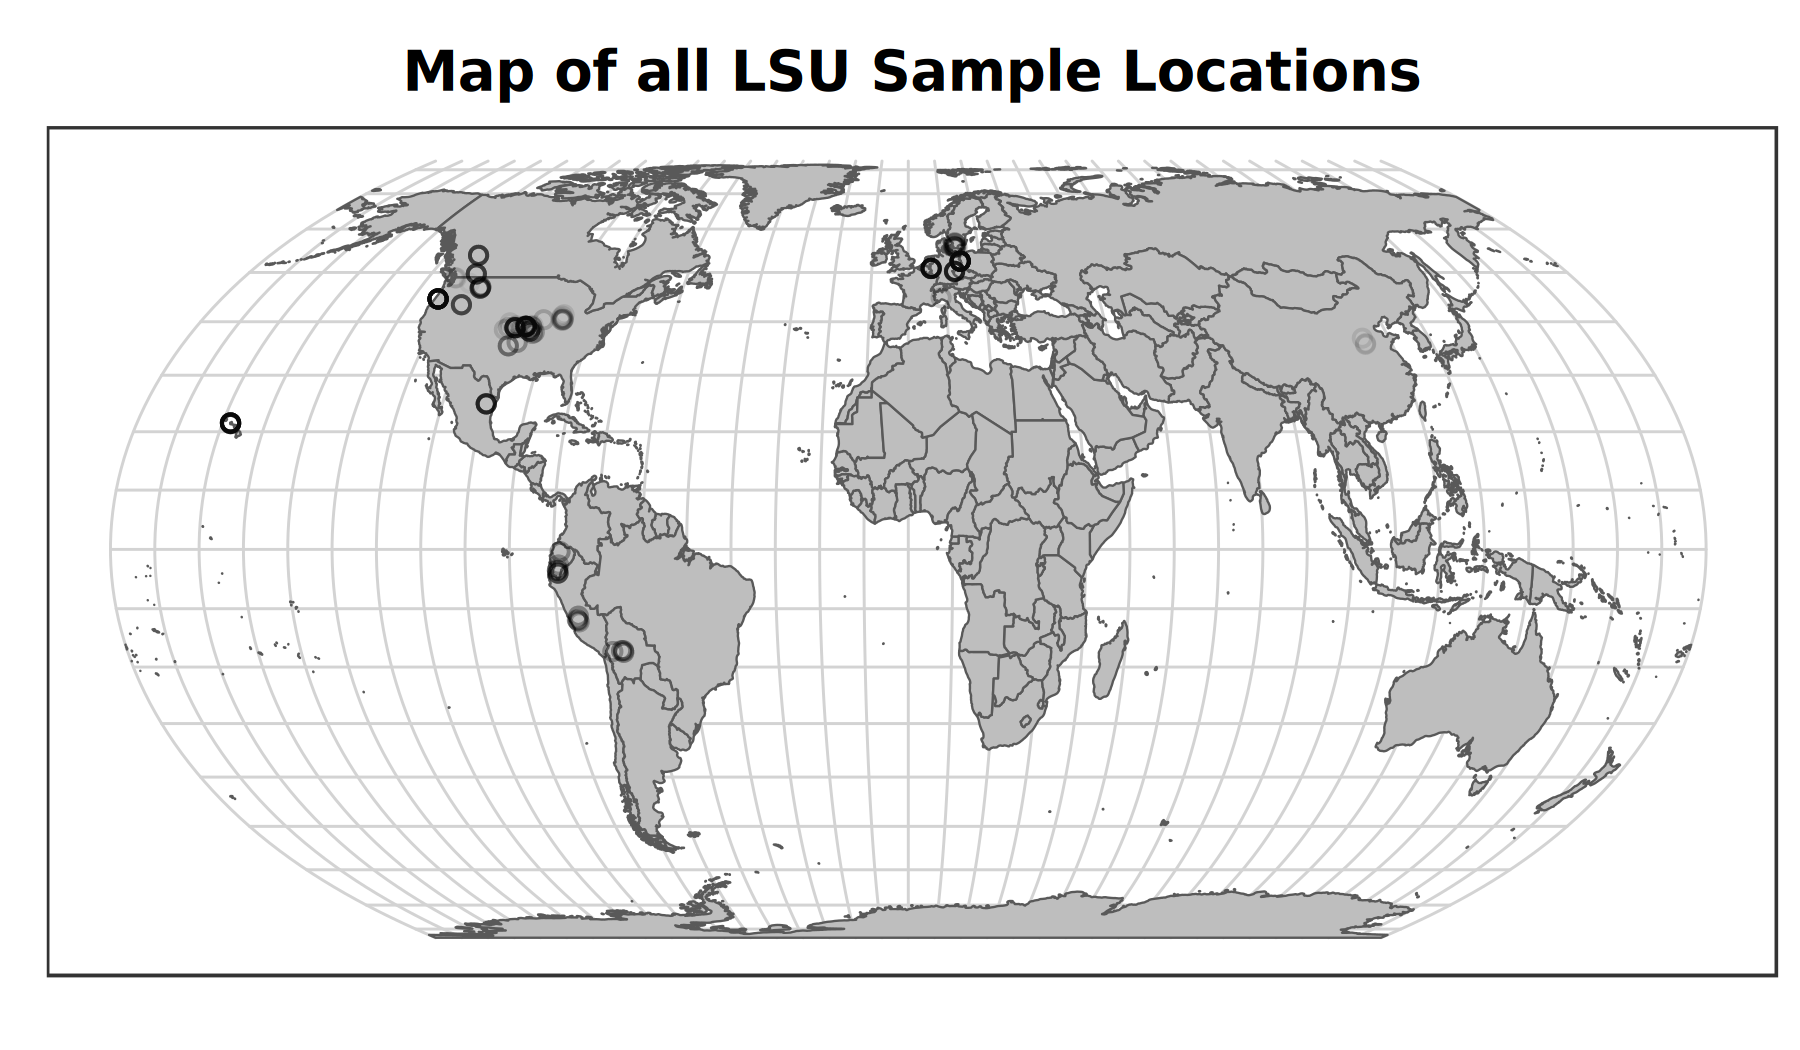

In [4]:
world <- ne_countries(scale = "medium", returnclass = "sf")
p <- ggplot(
  data = filter(tbl(con, "samples"), target_gene == "LSU")
) +
  geom_sf(
    data = world, fill = "grey", show.legend = FALSE
  ) +
  geom_point(
    aes(x = longitude, y = latitude),
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(crs = "WGS84 +proj=eqearth", default_crs = "EPSG:4326") +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 10)) +
  scale_y_continuous(breaks = seq(-90, 90, 10)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of all LSU Sample Locations"
  )
suppressWarnings(print(p))

In [5]:
count(tbl(con, "locations"), Genus) |> collect() |> arrange(desc(n))

Genus                              n     
1  Funneliformis                      284356
2  Rhizophagus                         68109
3  Claroideoglomus                     19145
4  Sclerocystis                         9617
5  Glomeraceae_spp                      6306
6  Rhizoglomus                          5940
7  Glomus                               5569
8  Dominikiaceae_spp                    4560
9  Septoglomus                          4466
10 Entrophospora                        3754
11 Microkamienskia                      3631
12 Dominikia                            3088
13 Diversispora                         3083
14 Paraglomus                           2664
15 Glomerales_spp                       2460
16 Acaulospora                          1953
17 Ambispora                            1287
18 Halonatospora                        1093
19 Sclerocystaceae_Kamienskiaceae_spp   1020
20 Otospora                              661
21 Dentiscutata                          520
22 Nanoglomus                            480
23 Innospora                             408
24 Diversisporaceae_spp                  390
25 Septoglomeraceae_spp                  360
26 Oehlia                                254
27 Gigaspora                             247
28 Scutellospora                         216
29 Complexispora                         210
30 Microdominikia                        194
31 Cetraspora                            168
32 Archaeospora                          108
33 Paracorymbiglomus                      90
34 Pacispora                              37
35 Redeckera                              33
36 Kamienskia                             32
37 Desertispora                           12

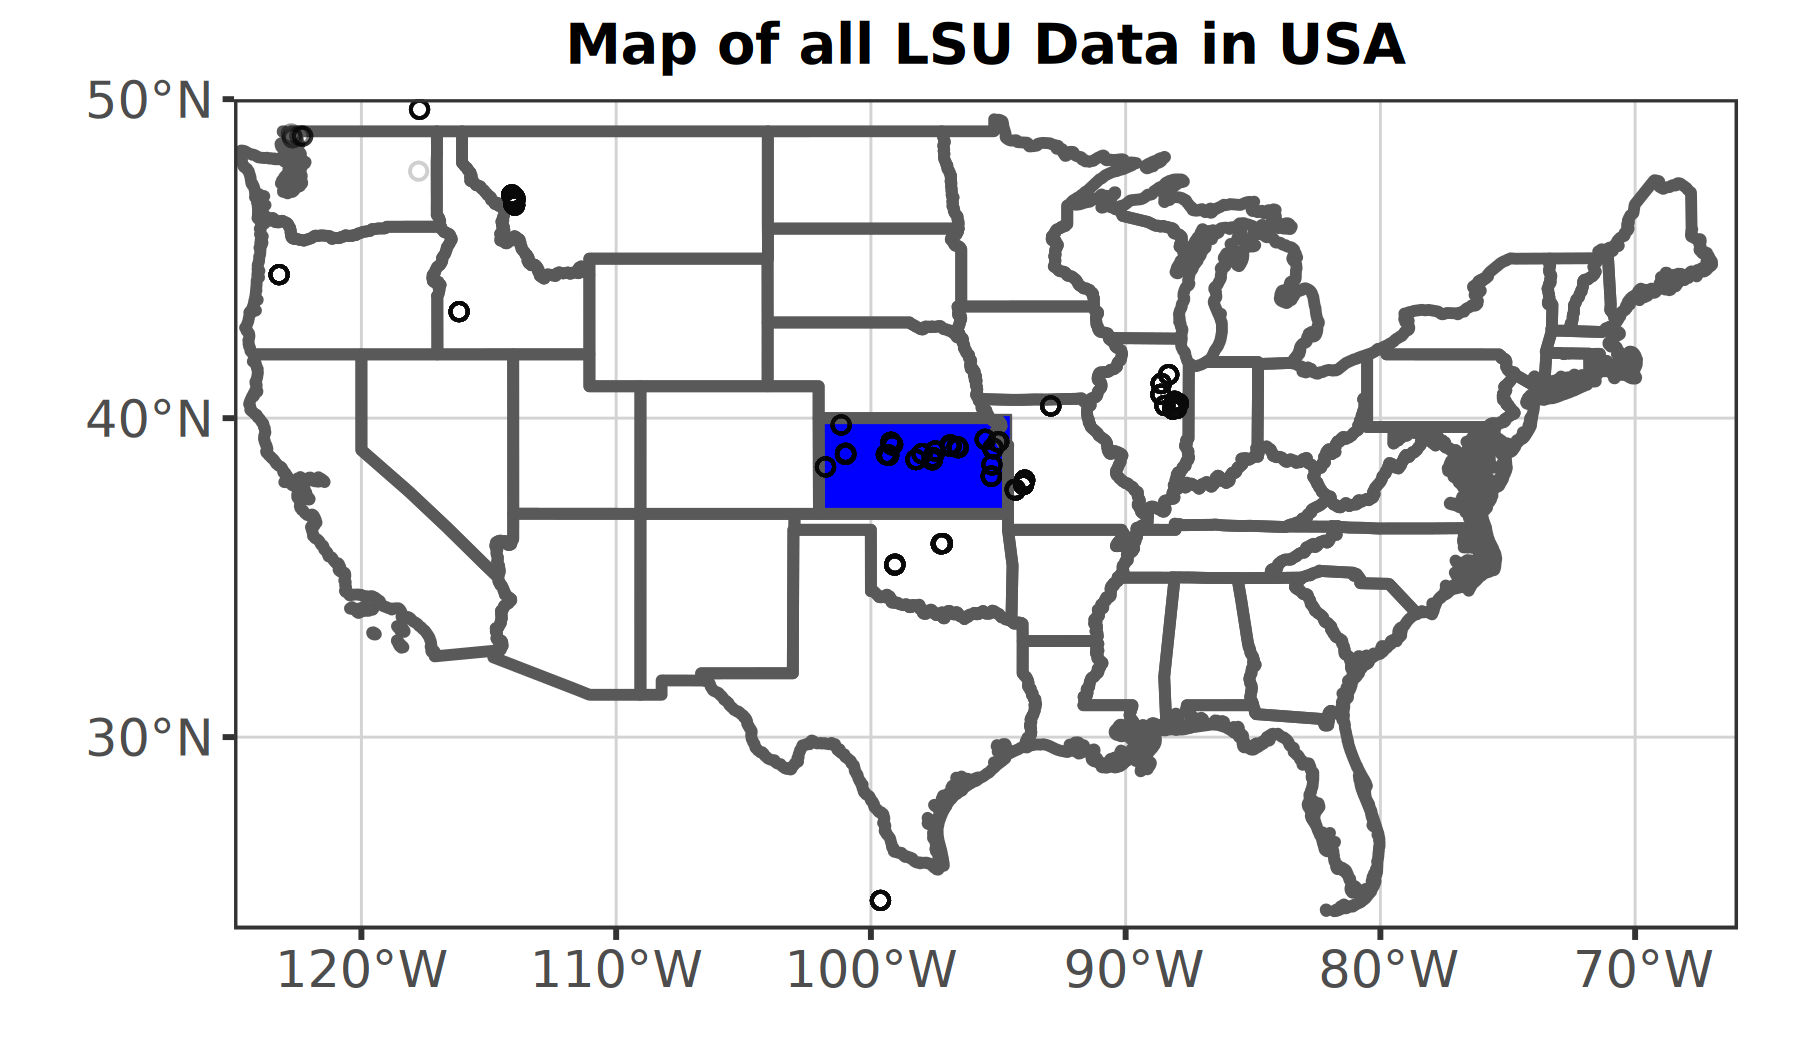

In [6]:
USA <- ne_states(country = "united states of america", returnclass = "sf")
p <- ggplot(
  # data = filter(tbl(con, "samples"), target_gene == "LSU")
  data = tbl(con, "locations")
) +
  geom_sf(
    data = st_as_sfc(
      st_bbox(
        c(xmin = -102.2, xmax = -94.5, ymin = 36.9, ymax = 40.1),
        crs = 4326
      )
    ), fill = "blue"
  ) +
  geom_sf(
    data = USA, fill = NA, linewidth = 1, show.legend = FALSE
  ) +
  geom_point(
    aes(x = longitude, y = latitude),
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(
    crs = "WGS84", default_crs = "WGS84",
    # xlim = c(-102.2, -94.5), ylim = c(36.9, 40.1), expand = FALSE
    xlim = c(-125, -66), ylim = c(24, 50), expand = FALSE
  ) +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 10)) +
  scale_y_continuous(breaks = seq(-90, 90, 10)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of all LSU Data in USA"
  )
suppressWarnings(print(p))

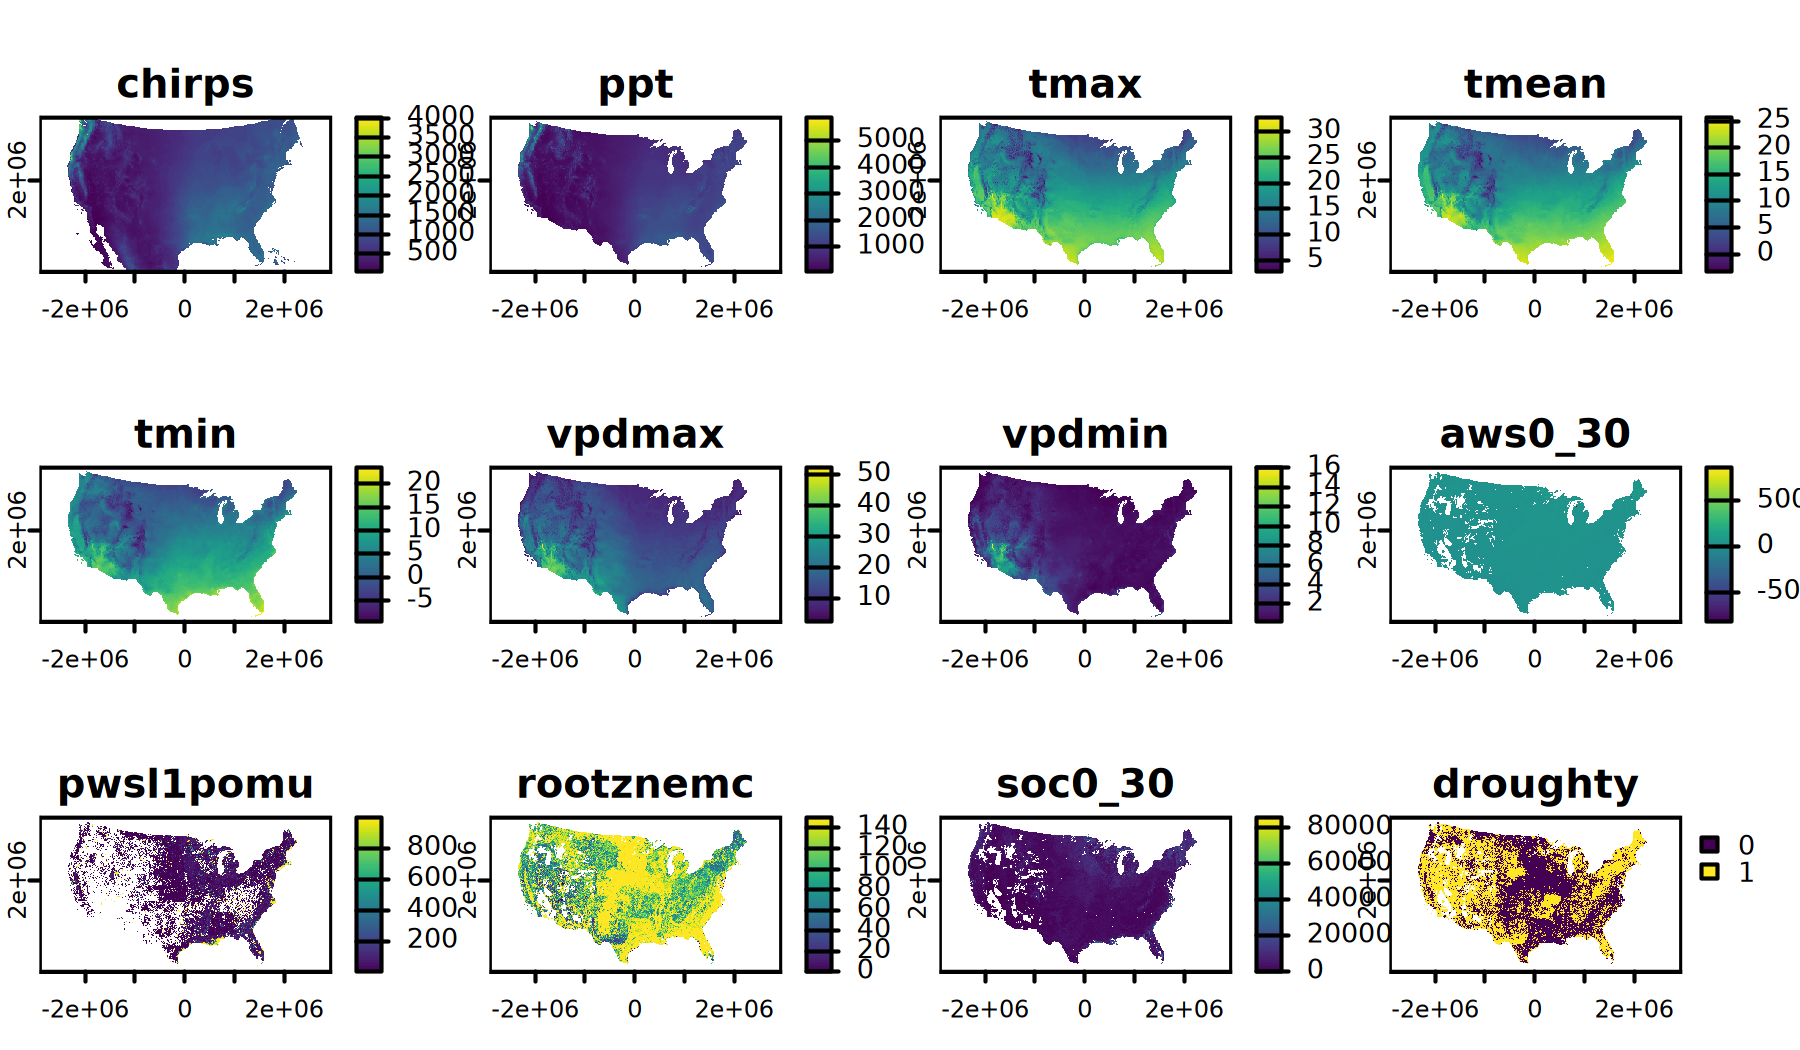

In [8]:
gis_dataset <- rast("../processing/gis/gis_data_1km.nc")
plot(gis_dataset)

# Midwest Only

Warning message:
“attribute variables are assumed to be spatially constant throughout all geometries”


Genus                              n   
1  Glomeraceae_spp                    6306
2  Rhizoglomus                        5940
3  Dominikiaceae_spp                  4560
4  Entrophospora                      3750
5  Dominikia                          2850
6  Glomus                             2688
7  Paraglomus                         2664
8  Glomerales_spp                     2460
9  Septoglomus                        2226
10 Diversispora                       1698
11 Acaulospora                        1650
12 Claroideoglomus                    1512
13 Rhizophagus                        1410
14 Sclerocystaceae_Kamienskiaceae_spp 1020
15 Funneliformis                       594
16 Nanoglomus                          480
17 Ambispora                           396
18 Diversisporaceae_spp                390
19 Septoglomeraceae_spp                360
20 Gigaspora                           246
21 Scutellospora                       216
22 Complexispora                       210
23 Cetraspora                          168
24 Archaeospora                        108
25 Paracorymbiglomus                    90
26 Kamienskia                           30

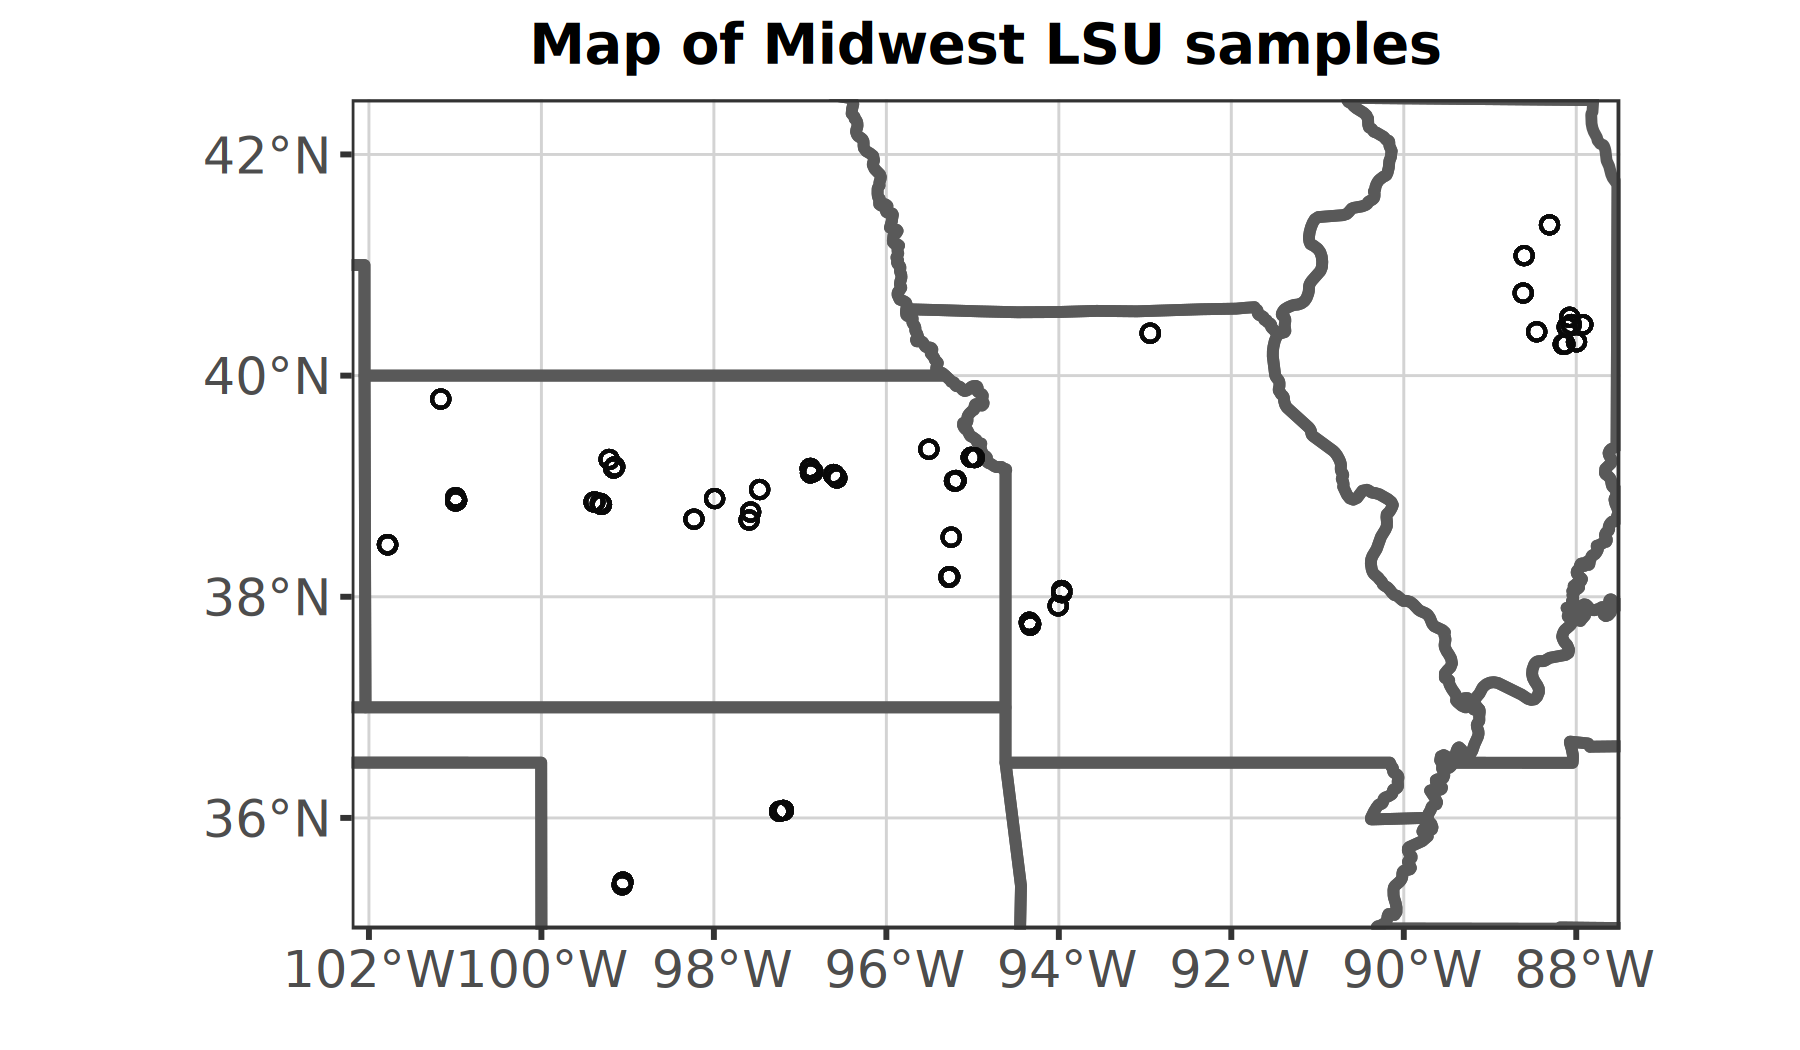

In [9]:
midwest_locations <- st_as_sf(
  collect(tbl(con, "locations")),
  coords = c("longitude", "latitude"),
  crs = 4326
) |>
  st_crop(
    st_bbox(
      c(xmin = -102.2, xmax = -87.5, ymin = 35, ymax = 42.5),
      crs = 4326
    )
  )
USA <- ne_states(country = "united states of america", returnclass = "sf")
p <- ggplot(
) +
  geom_sf(
    data = USA, fill = NA, linewidth = 1, show.legend = FALSE
  ) +
  geom_sf(
    data = midwest_locations,
    shape = 21, color = "black", fill = NA, alpha = 0.05
  ) +
  coord_sf(
    crs = "WGS84", default_crs = "WGS84",
    xlim = c(-102.2, -87.5), ylim = c(35, 42.5), expand = FALSE
  ) +
  theme(
    panel.grid = element_line(color = "lightgray", size = 0.25),
  ) +
  scale_x_continuous(breaks = seq(-180, 180, 2)) +
  scale_y_continuous(breaks = seq(-90, 90, 2)) +
  labs(
    x = element_blank(), y = element_blank(),
    title = "Map of Midwest LSU samples"
  )
suppressWarnings(print(p))
count(st_drop_geometry(midwest_locations), Genus) |> arrange(desc(n))

In [10]:
as.data.frame(midwest_locations) |> write.table(
  file = "midwest_data.tsv",
  row.names = FALSE, col.names = TRUE, sep = "\t"
)

`summarise()` has grouped output by 'sample_id', 'Genus'. You can override
using the `.groups` argument.
Warning message:
“[extract] transforming vector data to the CRS of the raster”


[1] "sample_id"  "Genus"      "Biome"      "abundance"  "total"     
 [6] "chirps"     "ppt"        "tmax"       "tmean"      "tmin"      
[11] "vpdmax"     "vpdmin"     "aws0_30"    "pwsl1pomu"  "rootznemc" 
[16] "soc0_30"    "droughty"   "proportion" "presence"

Genus                              n  
1  Acaulospora                        138
2  Ambispora                          138
3  Cetraspora                         138
4  Diversispora                       138
5  Funneliformis                      138
6  Gigaspora                          138
7  Glomeraceae_spp                    138
8  Glomus                             138
9  Paraglomus                         138
10 Septoglomus                        138
11 Archaeospora                       108
12 Claroideoglomus                    108
13 Rhizoglomus                        108
14 Scutellospora                      108
15 Complexispora                       30
16 Diversisporaceae_spp                30
17 Dominikia                           30
18 Dominikiaceae_spp                   30
19 Entrophospora                       30
20 Glomerales_spp                      30
21 Kamienskia                          30
22 Nanoglomus                          30
23 Paracorymbiglomus                   30
24 Rhizophagus                         30
25 Sclerocystaceae_Kamienskiaceae_spp  30
26 Septoglomeraceae_spp                30

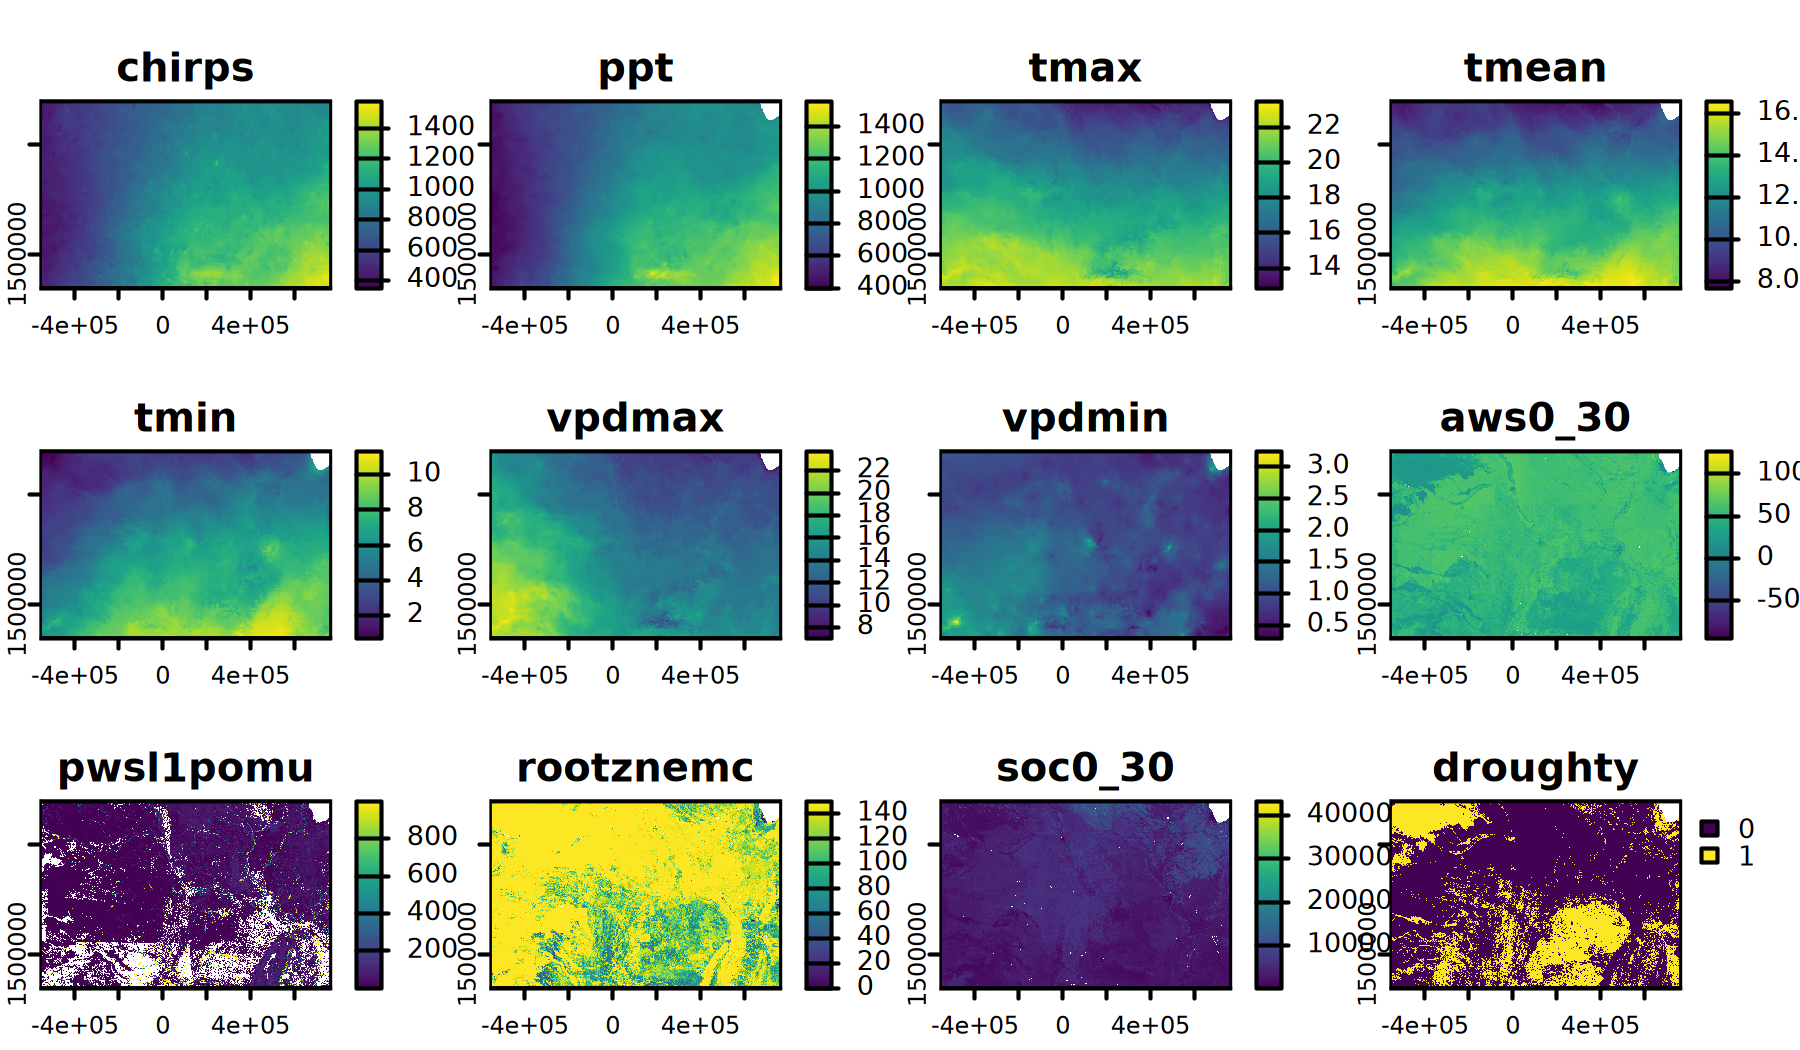

In [11]:
gis_dataset <- rast("../processing/gis/gis_data_1km.nc")
midwest_points <- summarize(
  group_by(midwest_locations, sample_id, Genus, Biome),
  abundance = sum(abundance),
  total = sum(total)
)
midwest_gis_dataset <- crop(
  gis_dataset,
  project(
    ext(c(-102.2, -87.5, 35, 42.5)),
    from = "EPSG:4326",
    to = "EPSG:5070"
  )
)
plot(midwest_gis_dataset)
extraction <- extract(midwest_gis_dataset, midwest_points)
dataset <- st_drop_geometry(cbind(midwest_points, extraction[, -1]))
dataset <- mutate(
  dataset,
  proportion = case_when(
    total > 0 ~ abundance / total,
    total == 0 ~ 0
  )
)
dataset <- mutate(
  dataset,
  presence = case_when(
    abundance > 0 ~ 1,
    abundance == 0 ~ 0
  )
)
colnames(dataset)
count(dataset, Genus) |> arrange(desc(n))

In [12]:
as.data.frame(dataset) |> write.table(
  file = "dataset.tsv",
  row.names = FALSE, col.names = TRUE, sep = "\t"
)

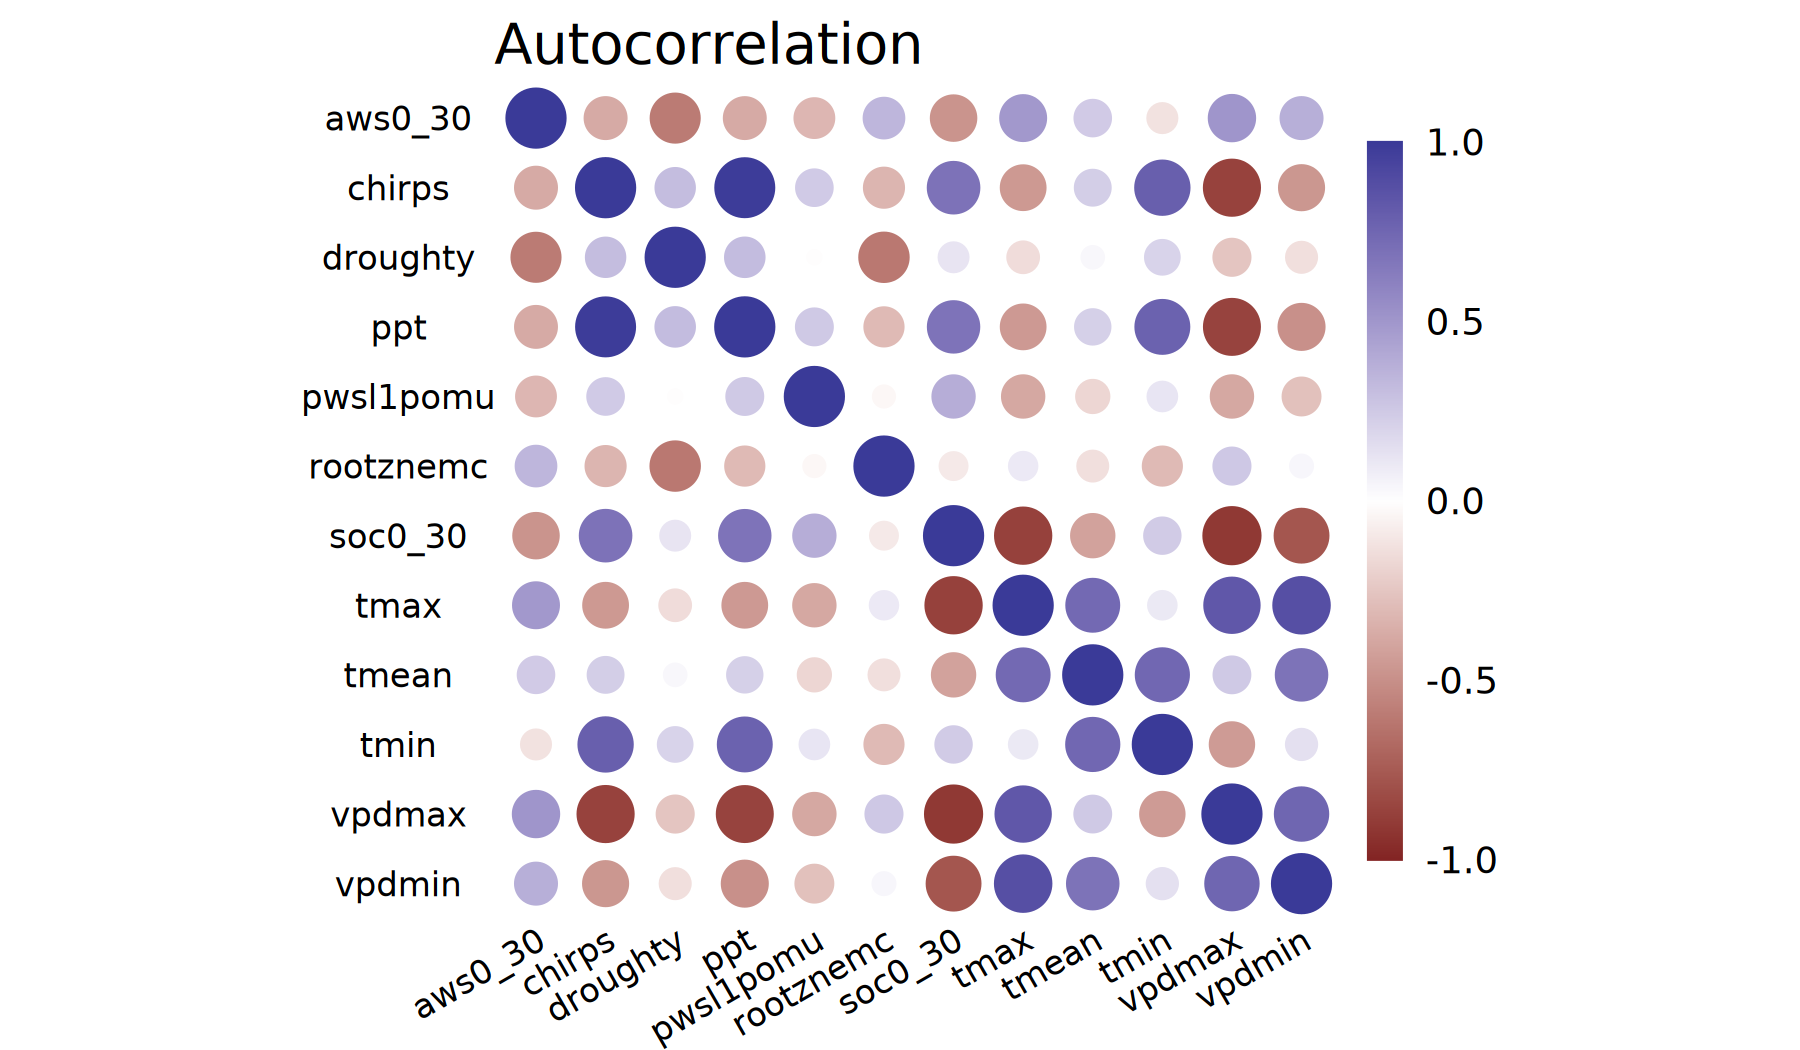

In [13]:
correlations <- cor(dataset[
  ,
  c(
    "aws0_30", # Available water storage estimate, expressed in mm
    "pwsl1pomu", # Potential Wetland Soil Landscapes is expressed as percentage
    "rootznemc", # Root zone depth, expressed in cm
    "soc0_30", # Soil organic carbon stock estimate, grams C per square meter
    "droughty", # “1” for a drought vulnerable soil or “0” for a non-droughty
    "chirps", # Annual Precipitation in 2020 (mm)
    "ppt", # Mean Precip 30 year normal (mm)
    "tmax", # Max Temp 30 year normal (C)
    "tmin", # Min Temp 30 year normal (C)
    "tmean", # Mean Temp 30 year normal (C)
    "vpdmax", # Daily Maximum Vapor Pressure Deficit 30 year normal (hPa)
    "vpdmin" # Daily Minimum Vapor Pressure Deficit 30 year normal (hPa)
  )
], use = "complete.obs")

ggplot(
  data = pivot_longer(
    as_tibble(correlations, rownames = "Var1"),
    cols = !Var1, names_to = "Var2"
  ),
  aes(x = Var1, y = Var2)
) +
  geom_point(aes(color = value, size = abs(value))) +
  guides(size = "none") +
  scale_color_gradient2(
    name = NULL, midpoint = 0, mid = "white", limits = c(-1, +1),
    na.value = "white",
  ) +
  scale_x_discrete(position = "bottom") +
  scale_y_discrete(limits = rev) +
  theme_void() +
  theme(
    axis.text.x = element_text(hjust = 1, vjust = 1, angle = 30, size = 8),
    axis.text.y = element_text(size = 8),
    aspect.ratio = 1,
    legend.key.width  = rel(0.5),
    legend.key.height = rel(2),
    legend.ticks = element_blank()
  ) +
  labs(
    title = "Autocorrelation", x = NULL, y = NULL,
  )

## Biome as a factor

[1] "anthropogenic" "grassland"

[1] "0" "1"

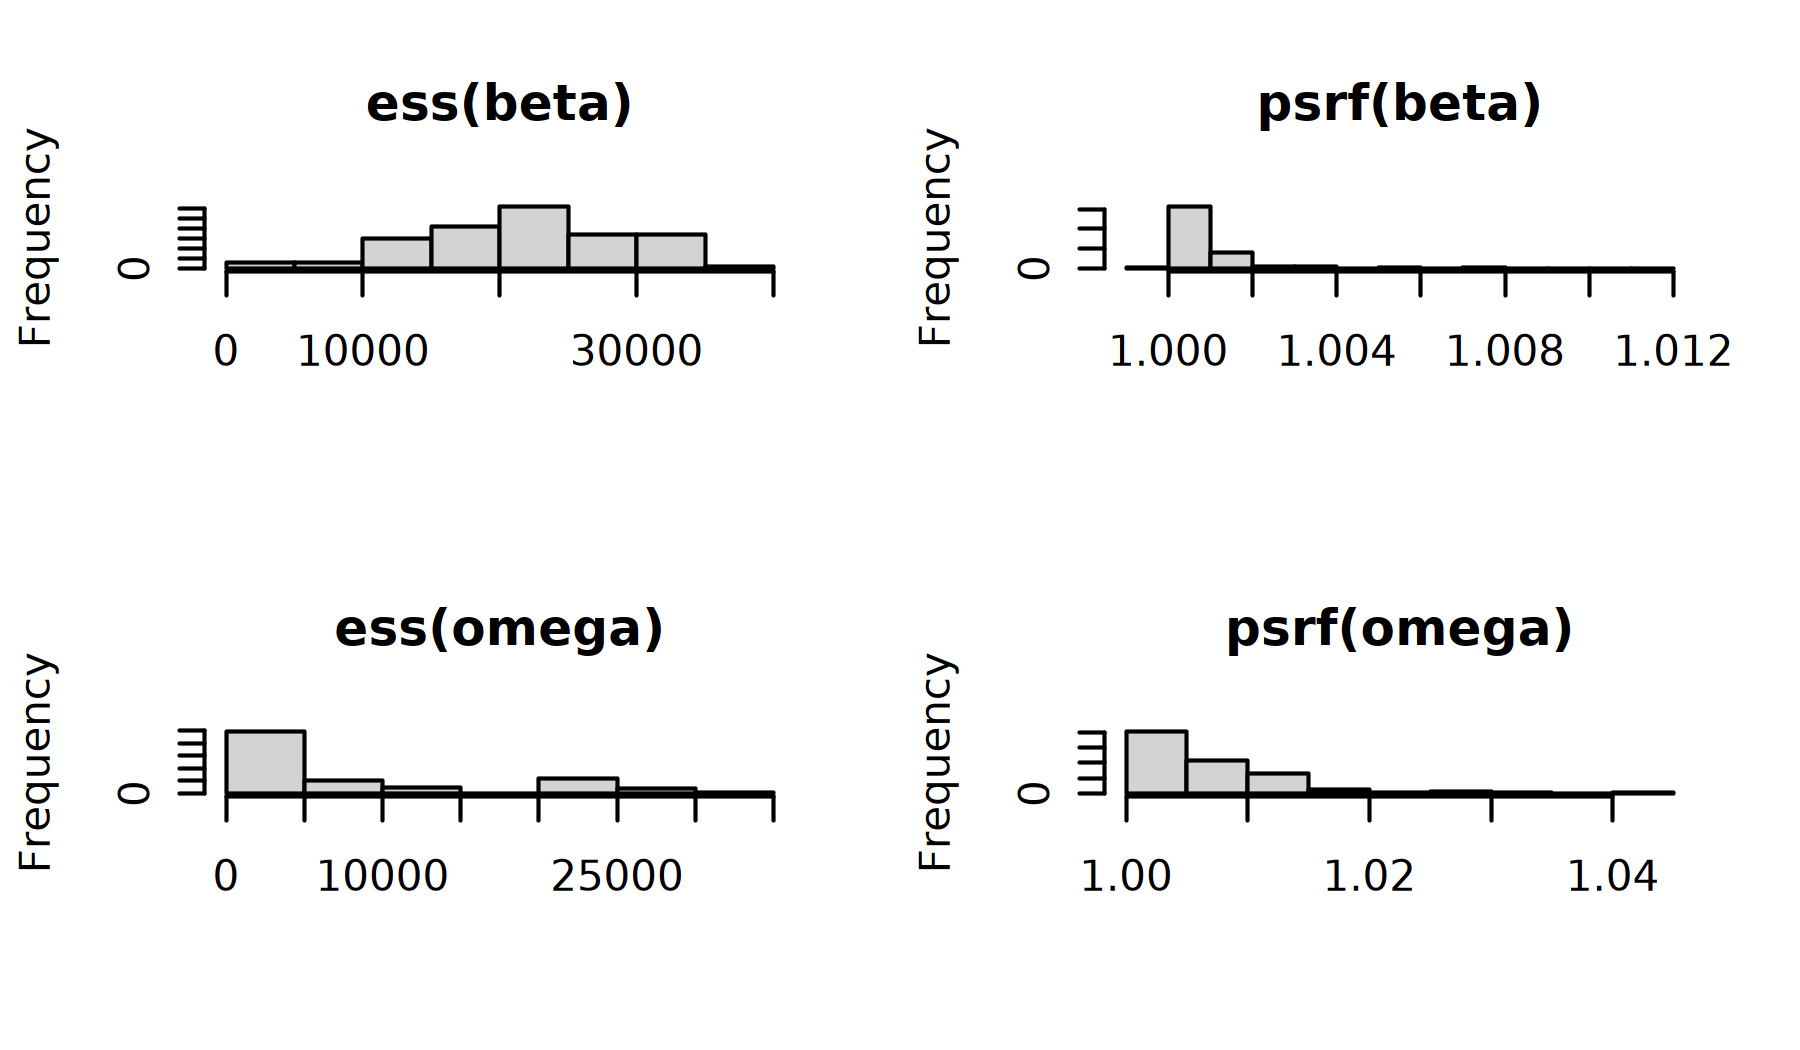

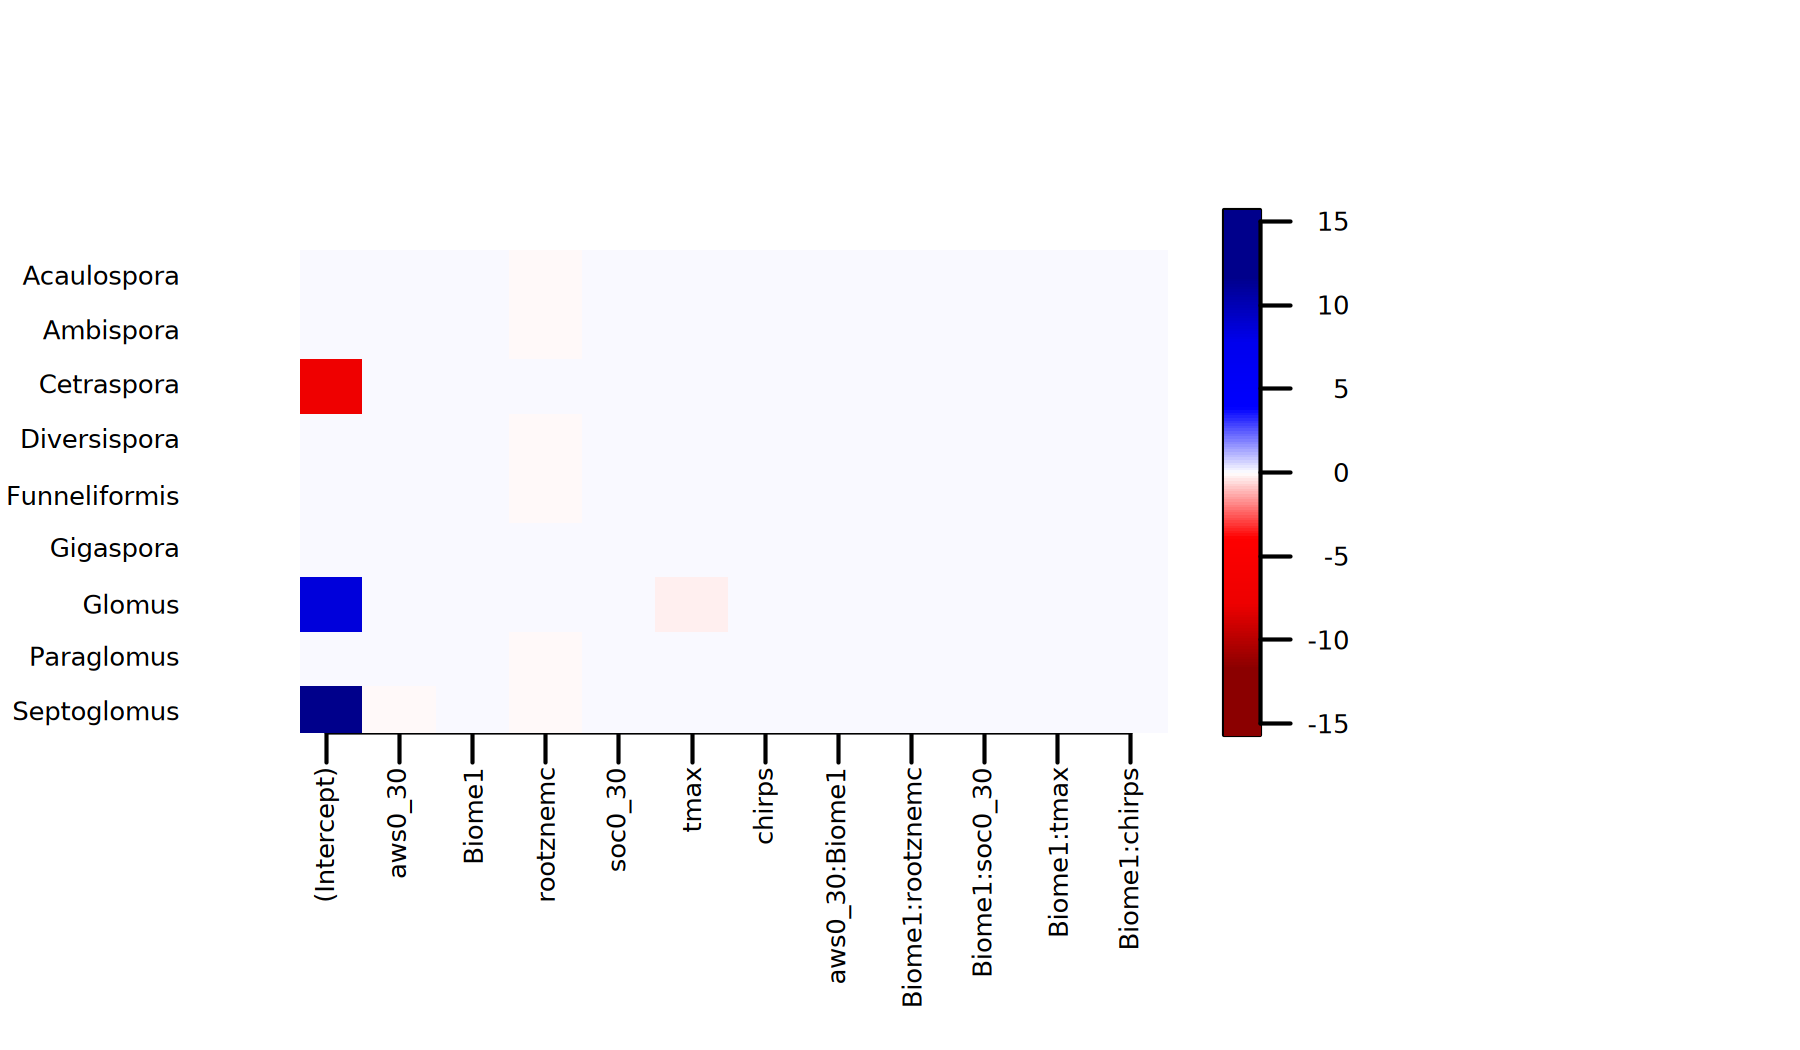

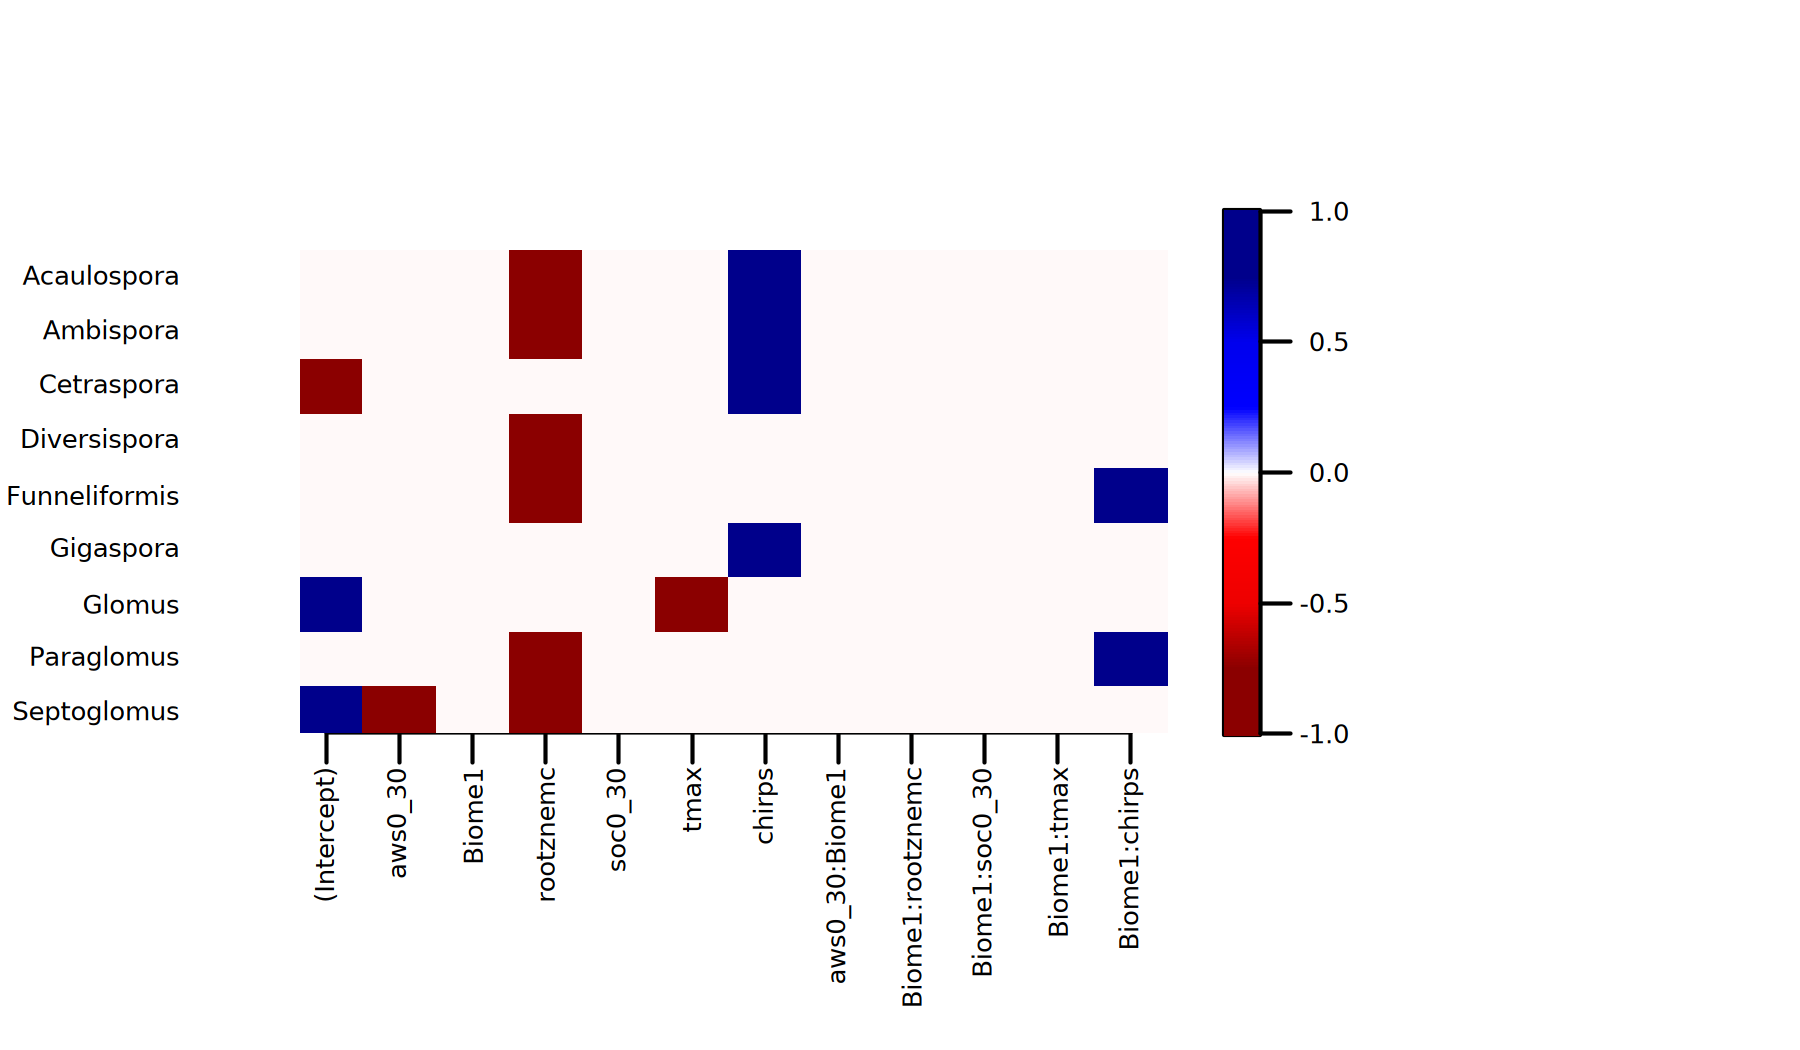

$RMSE
[1] 0.2716281 0.3260952 0.2373266 0.3141344 0.3929666 0.2976852 0.3748130
[8] 0.3326840 0.2032099

$AUC
[1] 0.9894426 0.8298738 0.9417989 0.9438153 0.8524150 0.9300567 0.8489596
[8] 0.9324913 0.9902597

$TjurR2
[1] 0.5614845 0.1655003 0.1978577 0.4843220 0.2811622 0.2659203 0.3054381
[8] 0.4304161 0.6191486

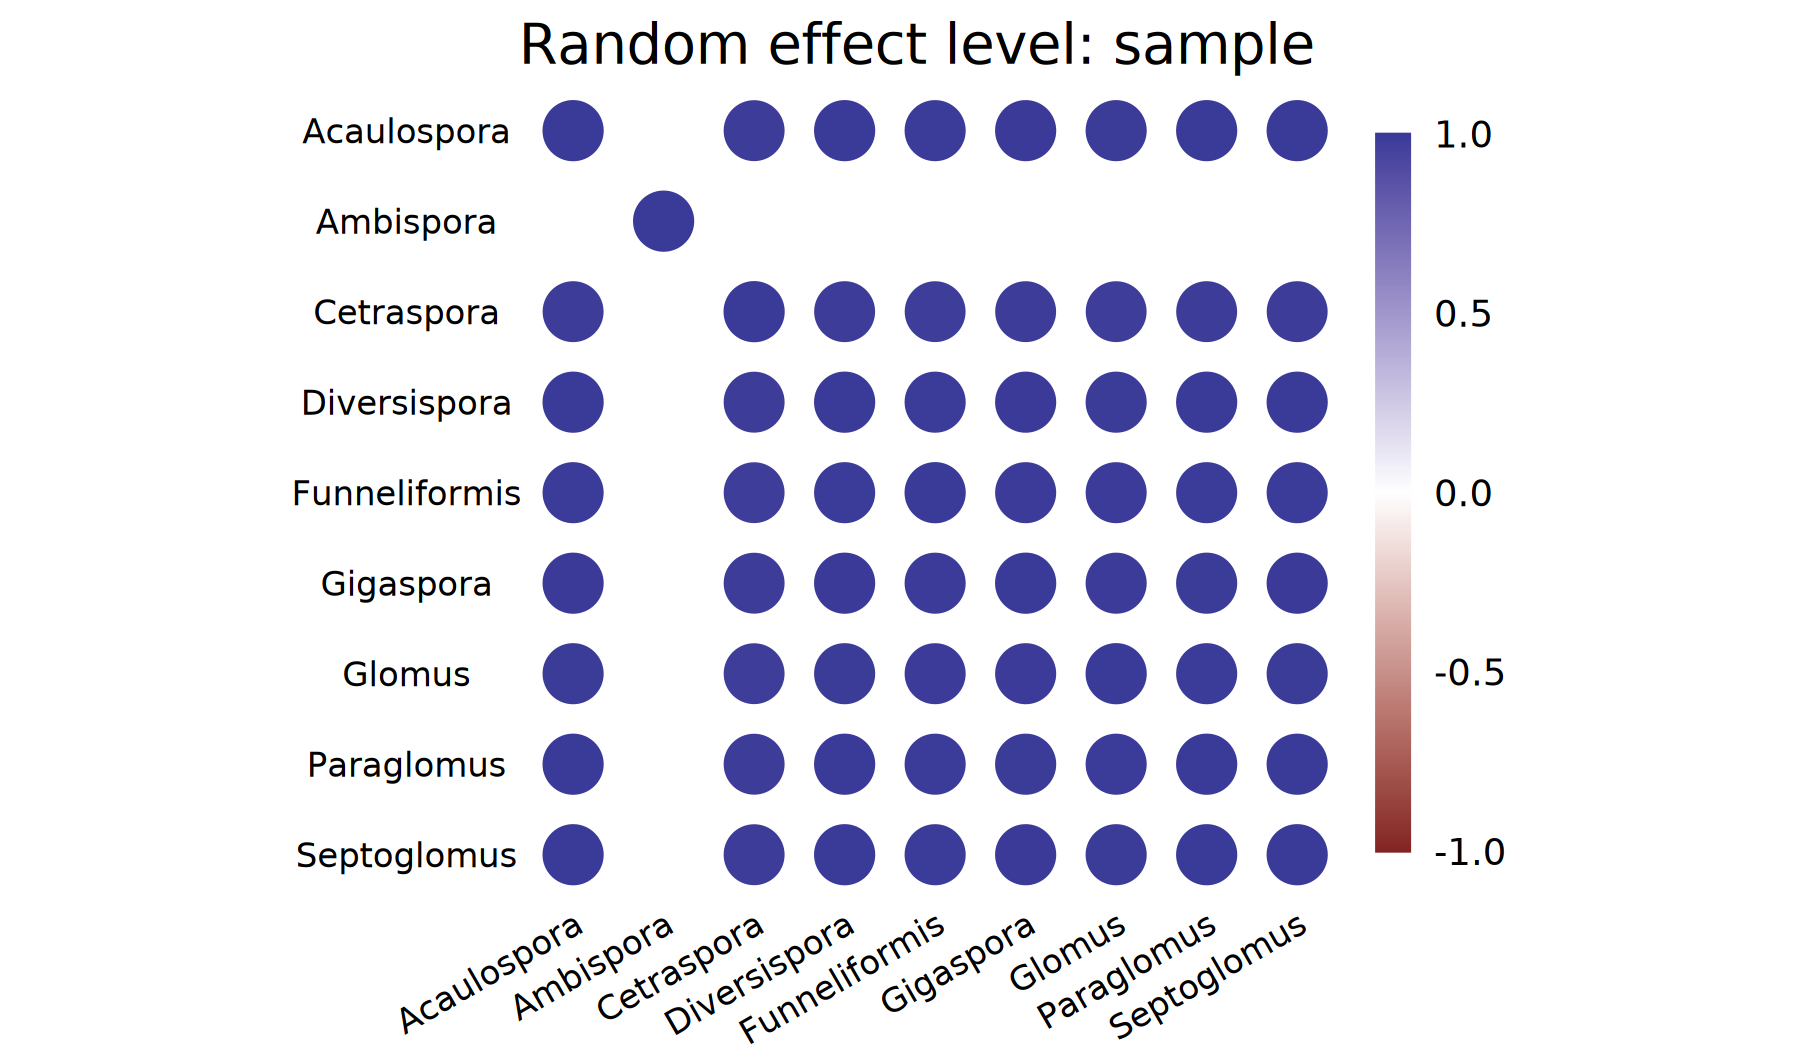

In [26]:
genus_names <- c(
  "Acaulospora", "Ambispora", "Cetraspora", "Diversispora",
  "Funneliformis", "Gigaspora", "Glomus", "Paraglomus", "Septoglomus"
)
dataset_wide <- pivot_wider(
  dataset[
    dataset$Genus %in% genus_names,
    !(colnames(dataset) %in% c("abundance", "total", "proportion"))
  ],
  names_from = Genus, values_from = presence
)
as.data.frame(dataset_wide) |> write.table(
  file = "dataset_wide.tsv",
  row.names = FALSE, col.names = TRUE, sep = "\t"
)

dataset_wide <- mutate(
  dataset_wide,
  across(c(Biome, droughty), ~ as.factor(.x))
)

predictors <- c(
  # "pwsl1pomu", # Removed due to NA values
  "aws0_30", # Available water storage estimate, expressed in mm
  "rootznemc", # Root zone depth, expressed in cm
  "soc0_30", # Soil organic carbon stock estimate, grams C per square meter
  # "droughty", # “1” for a drought vulnerable soil or “0” for a non-droughty
  "tmax", # Max Temp 30 year normal (C)
  # "tmin", # Min Temp 30 year normal (C)
  # "tmean", # Mean Temp 30 year normal (C)
  # "vpdmax", # Daily Maximum Vapor Pressure Deficit 30 year normal (hPa)
  # "vpdmin", # Daily Minimum Vapor Pressure Deficit 30 year normal (hPa)
  "chirps", # Annual Precipitation in 2020 (mm)
  "Biome" # Not in GIS layers
)

m <- Hmsc(
  Y = dataset_wide[genus_names],
  XData = dataset_wide[predictors],
  XFormula = ~
    aws0_30 * Biome +
    rootznemc * Biome +
    soc0_30 * Biome +
    tmax * Biome +
    chirps * Biome +
    # droughty * Biome +
    # pwsl1pomu +
    # tmin * Biome +
    # tmean * Biome +
    # vpdmax * Biome +
    # vpdmin * Biome +
    # aws0_30 +
    # rootznemc +
    # soc0_30 +
    # tmax +
    # chirps +
    # droughty +
    # pwsl1pomu +
    # tmin +
    # tmean +
    # vpdmax +
    # vpdmin +
    Biome,
  studyDesign = data.frame(sample = as.factor(row.names(dataset_wide))),
  ranLevels = list(
    sample = HmscRandomLevel(units = as.factor(row.names(dataset_wide)))
  ),
  distr = "probit"
)
m <- sampleMcmc(
  m,
  thin = 5,
  samples = 5000,
  transient = 500,
  nChains = 8,
  nParallel = 8,
  verbose = 1
)
levels(dataset_wide$Biome)
levels(dataset_wide$droughty)

mpost <- convertToCodaObject(m)
par(mfrow = c(2, 2))
hist(effectiveSize(mpost$Beta), main = "ess(beta)", xlab = NULL)
hist(
  gelman.diag(mpost$Beta, multivariate = FALSE)$psrf,
  main = "psrf(beta)", xlab = NULL
)
hist(effectiveSize(mpost$Omega[[1]]), main = "ess(omega)", xlab = NULL)
hist(
  gelman.diag(mpost$Omega[[1]], multivariate = FALSE)$psrf,
  main = "psrf(omega)", xlab = NULL
)

par(mfrow = c(1, 1))
post_eta <- getPostEstimate(m, parName = "Beta")
plotBeta(
  m, post = post_eta, param = "Mean", supportLevel = 0.95,
  mar = c(5.3, 5, 0, 0), cex = c(0.5, 0.5, 0.5),
  spNamesNumbers = c(1, 0), covNamesNumbers = c(1, 0),
  smallplot = c(0.68, 0.7, 0.3, 0.8), mgp = c(0, 1.5, 0),
  colors = colorRampPalette(
    c(
      "red4", "red4", "red2", "red1", "white",
      "blue1", "blue2", "blue4", "blue4"
    )
  )
)
post_eta <- getPostEstimate(m, parName = "Beta")
plotBeta(
  m, post = post_eta, param = "Support", supportLevel = 0.95,
  mar = c(5.3, 5, 0, 0), cex = c(0.5, 0.5, 0.5),
  spNamesNumbers = c(1, 0), covNamesNumbers = c(1, 0),
  smallplot = c(0.68, 0.7, 0.3, 0.8), mgp = c(0, 1.5, 0),
  colors = colorRampPalette(
    c(
      "red4", "red4", "red2", "red1", "white",
      "blue1", "blue2", "blue4", "blue4"
    )
  )
)

omega_cor <- computeAssociations(m)
support_level <- 0.95
significant_omega_mean <- (
  (omega_cor[[1]]$support > support_level) +
    (omega_cor[[1]]$support < (1 - support_level)) > 0
) * omega_cor[[1]]$mean

# significant_omega_mean[lower.tri(significant_omega_mean)] <- NA
ggplot(
  data = pivot_longer(
    as_tibble(significant_omega_mean, rownames = "Var1"),
    cols = !Var1, names_to = "Var2"
  ),
  aes(x = Var1, y = Var2)
) +
  geom_point(aes(color = value, size = abs(value))) +
  guides(size = "none") +
  scale_color_gradient2(
    name = NULL, midpoint = 0, mid = "white", limits = c(-1, +1),
    na.value = "white",
  ) +
  scale_x_discrete(position = "bottom") +
  scale_y_discrete(limits = rev) +
  theme_void() +
  theme(
    axis.text.x = element_text(hjust = 1, vjust = 1, angle = 30, size = 8),
    axis.text.y = element_text(size = 8),
    aspect.ratio = 1,
    legend.key.width  = rel(0.5),
    legend.key.height = rel(2),
    legend.ticks = element_blank()
  ) +
  labs(
    title = paste("Random effect level:", m$rLNames[1]), x = NULL, y = NULL,
  )

preds <- computePredictedValues(m)
evaluateModelFit(hM = m, predY = preds)


In [27]:
partition <- createPartition(m, nfolds = 2)
preds <- computePredictedValues(m, partition = partition, nParallel = 8)
evaluateModelFit(hM = m, predY = preds)

Cross-validation, fold 1 out of 2
Cross-validation, fold 2 out of 2


$RMSE
[1] 0.5170064 0.3892255 0.2890951 0.4896806 0.4760864 0.3740536 0.4764417
[8] 0.4680496 0.3736983

$AUC
[1] 0.6000845 0.5636956 0.5535714 0.6138937 0.6460197 0.6136106 0.6139535
[8] 0.6620209 0.7571429

$TjurR2
[1]  0.086277727 -0.001658433  0.005471006  0.102485679  0.113968972
[6]  0.045994794  0.105024670  0.124102554  0.215942219

## Native Grassland Samples

[1] "anthropogenic" "grassland"

[1] "0" "1"

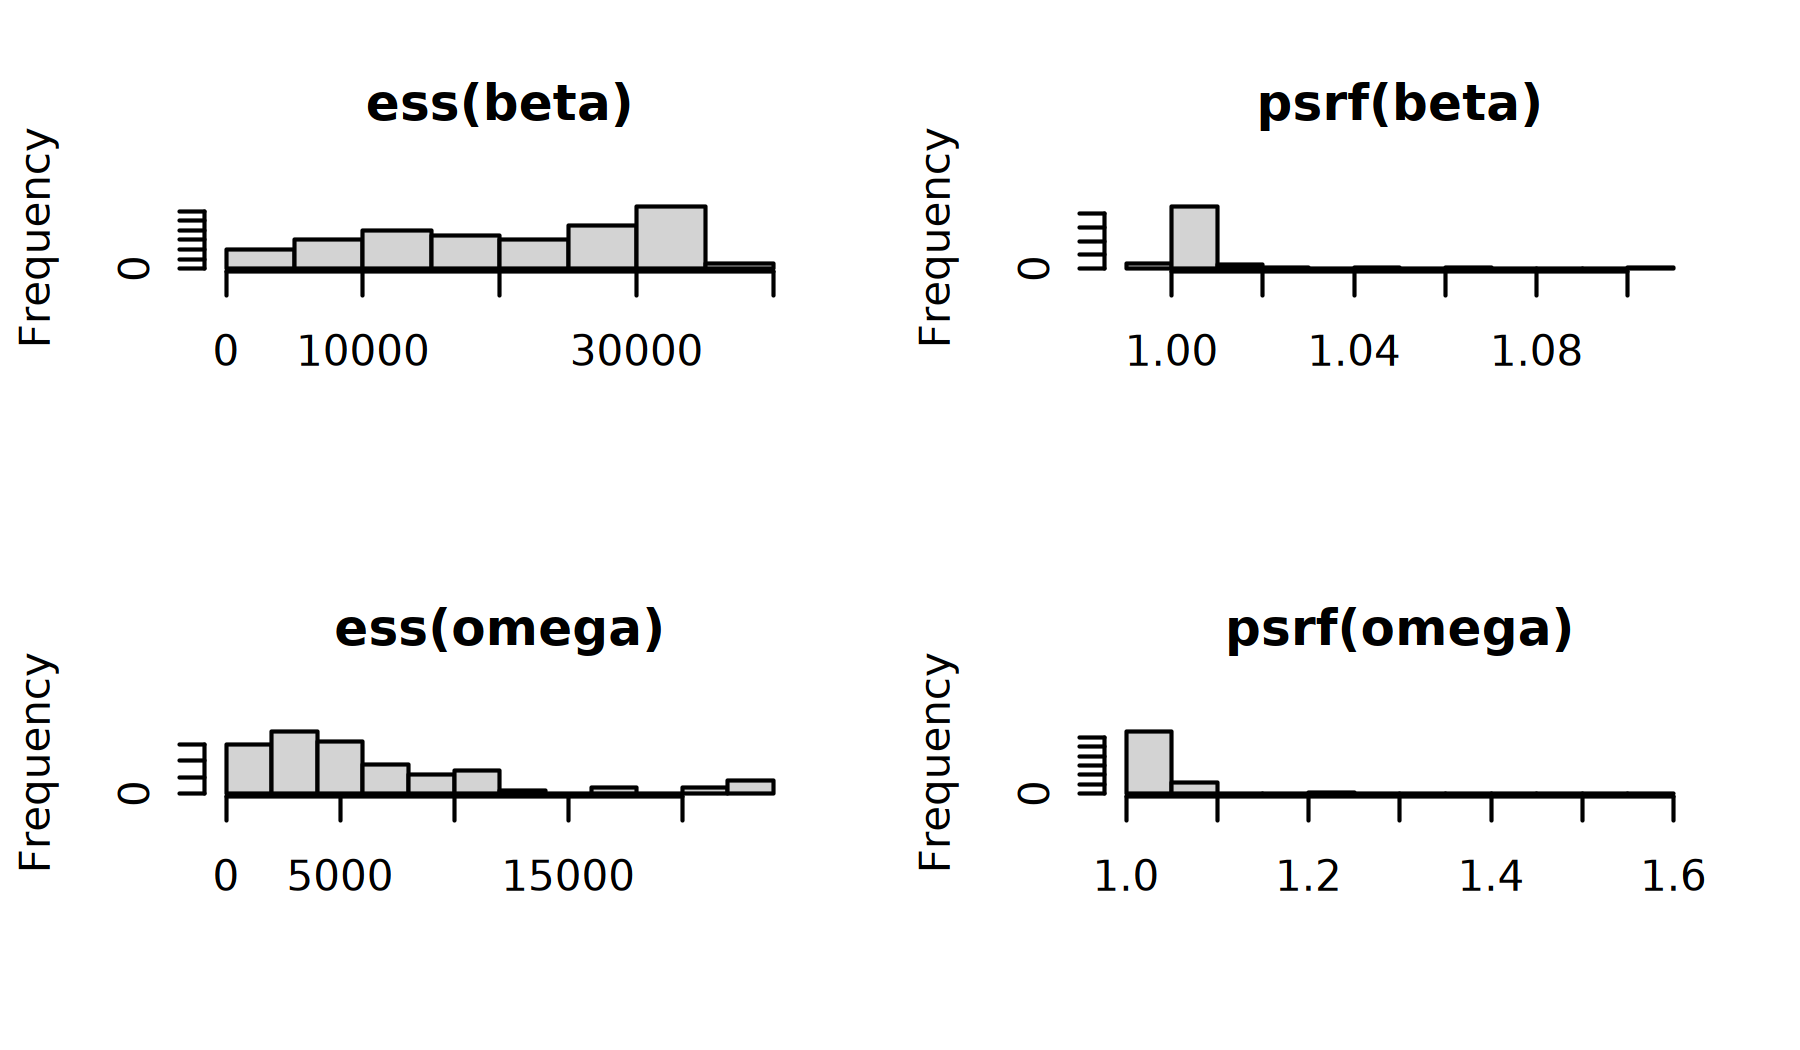

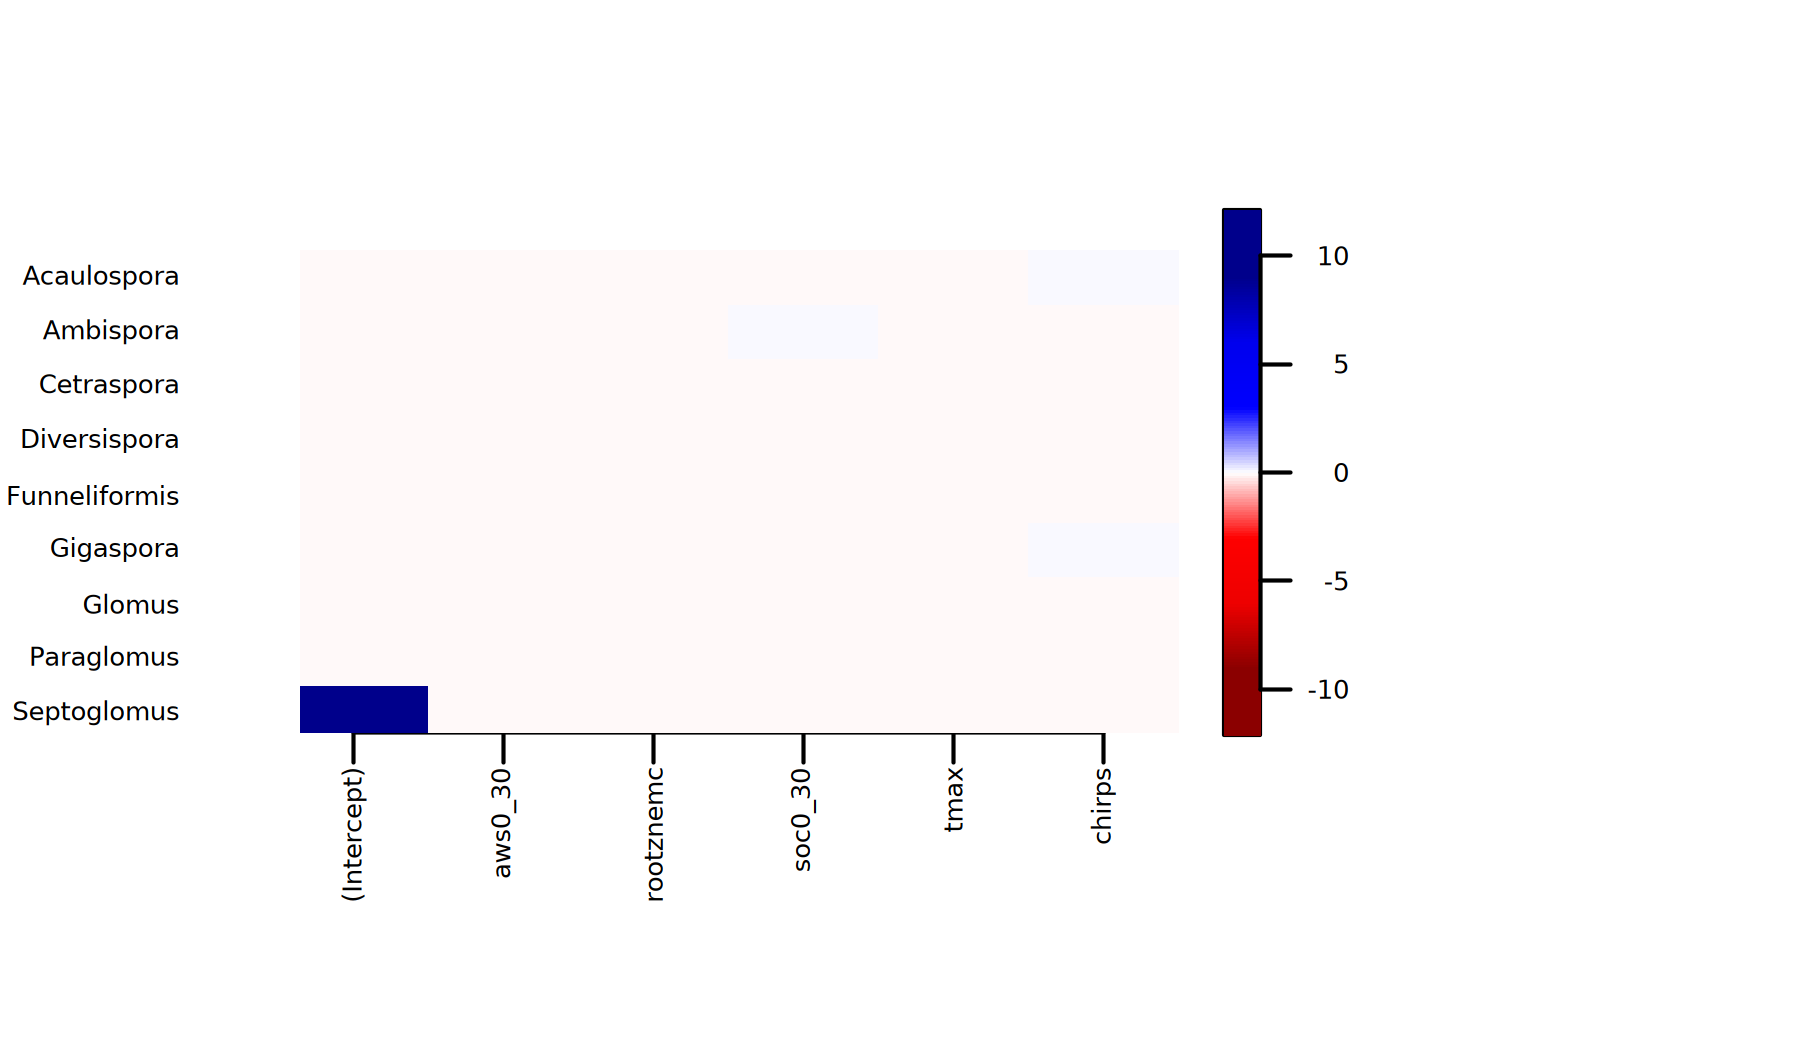

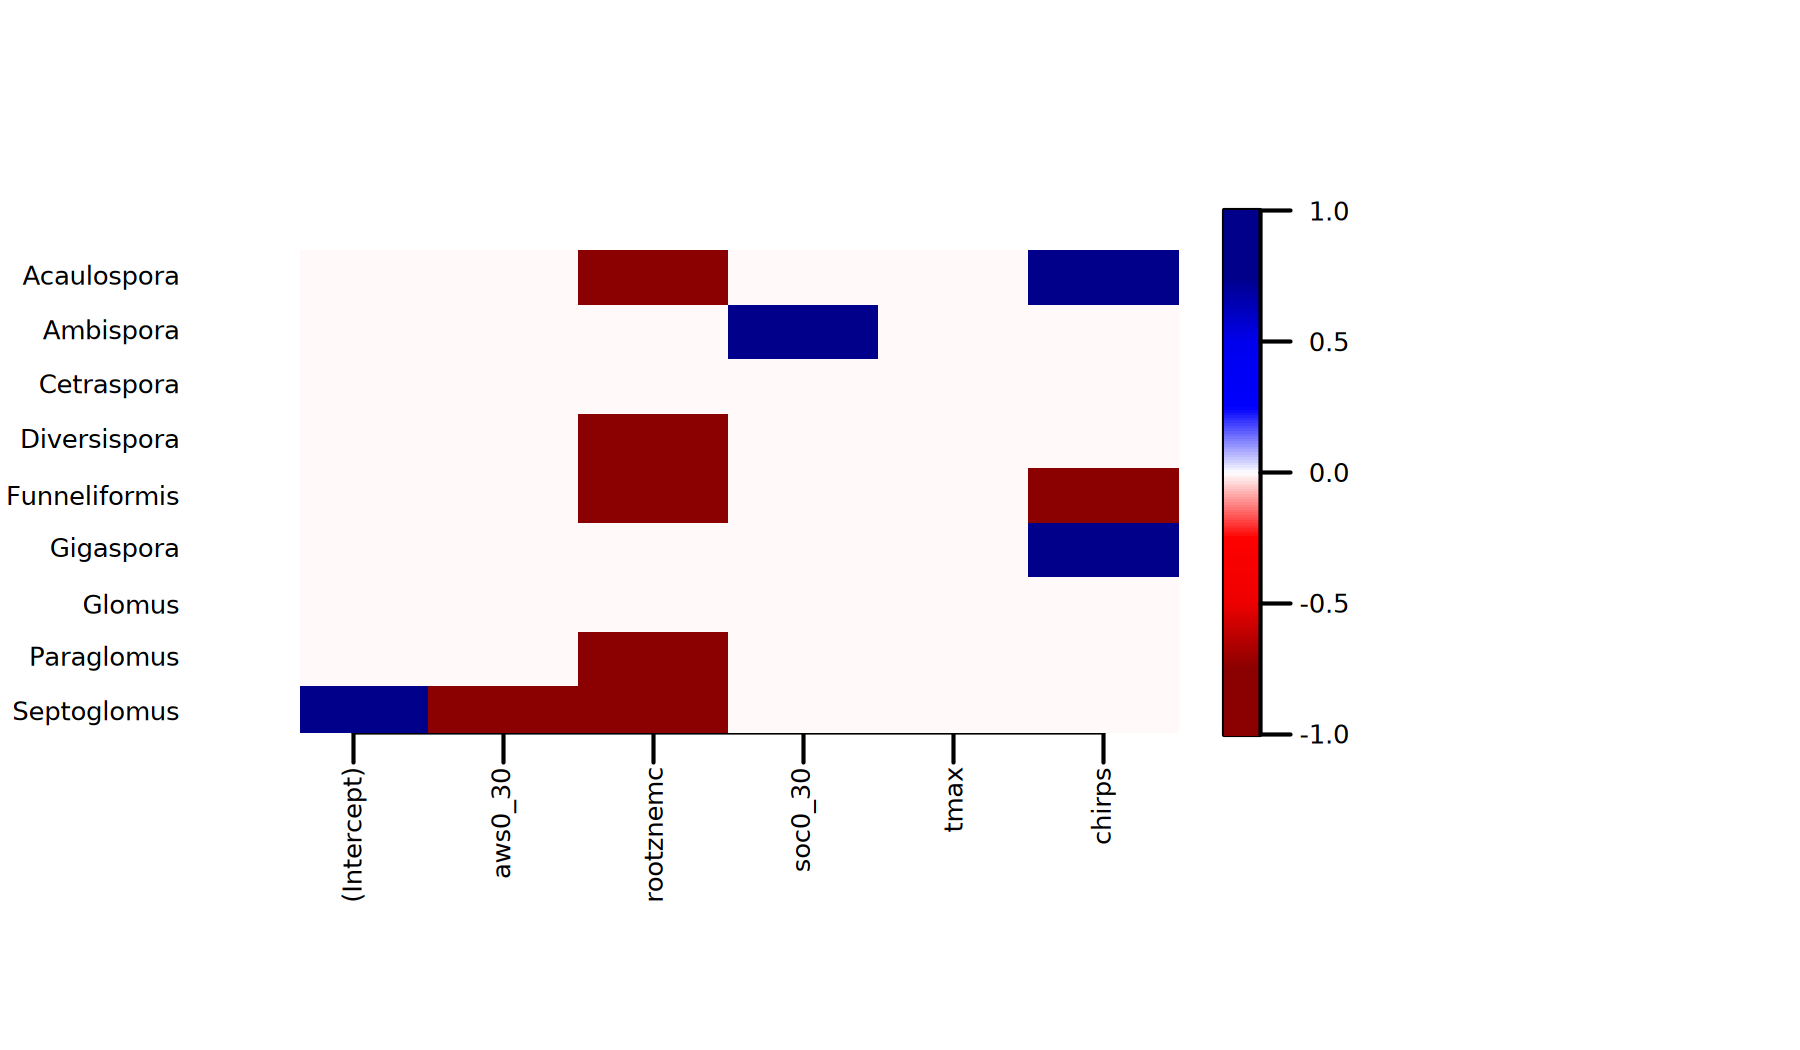

$RMSE
[1] 0.3595507 0.3832824 0.2699129 0.3917139 0.4108052 0.3743850 0.3289895
[8] 0.3407714 0.2414568

$AUC
[1] 0.9625199 0.8034091 0.9620536 0.8679078 0.7854701 0.7904762 0.9119048
[8] 0.9166667 0.9557377

$TjurR2
[1] 0.3348212 0.1375864 0.1065286 0.2279516 0.2381219 0.1324172 0.2609664
[8] 0.3864166 0.4111660

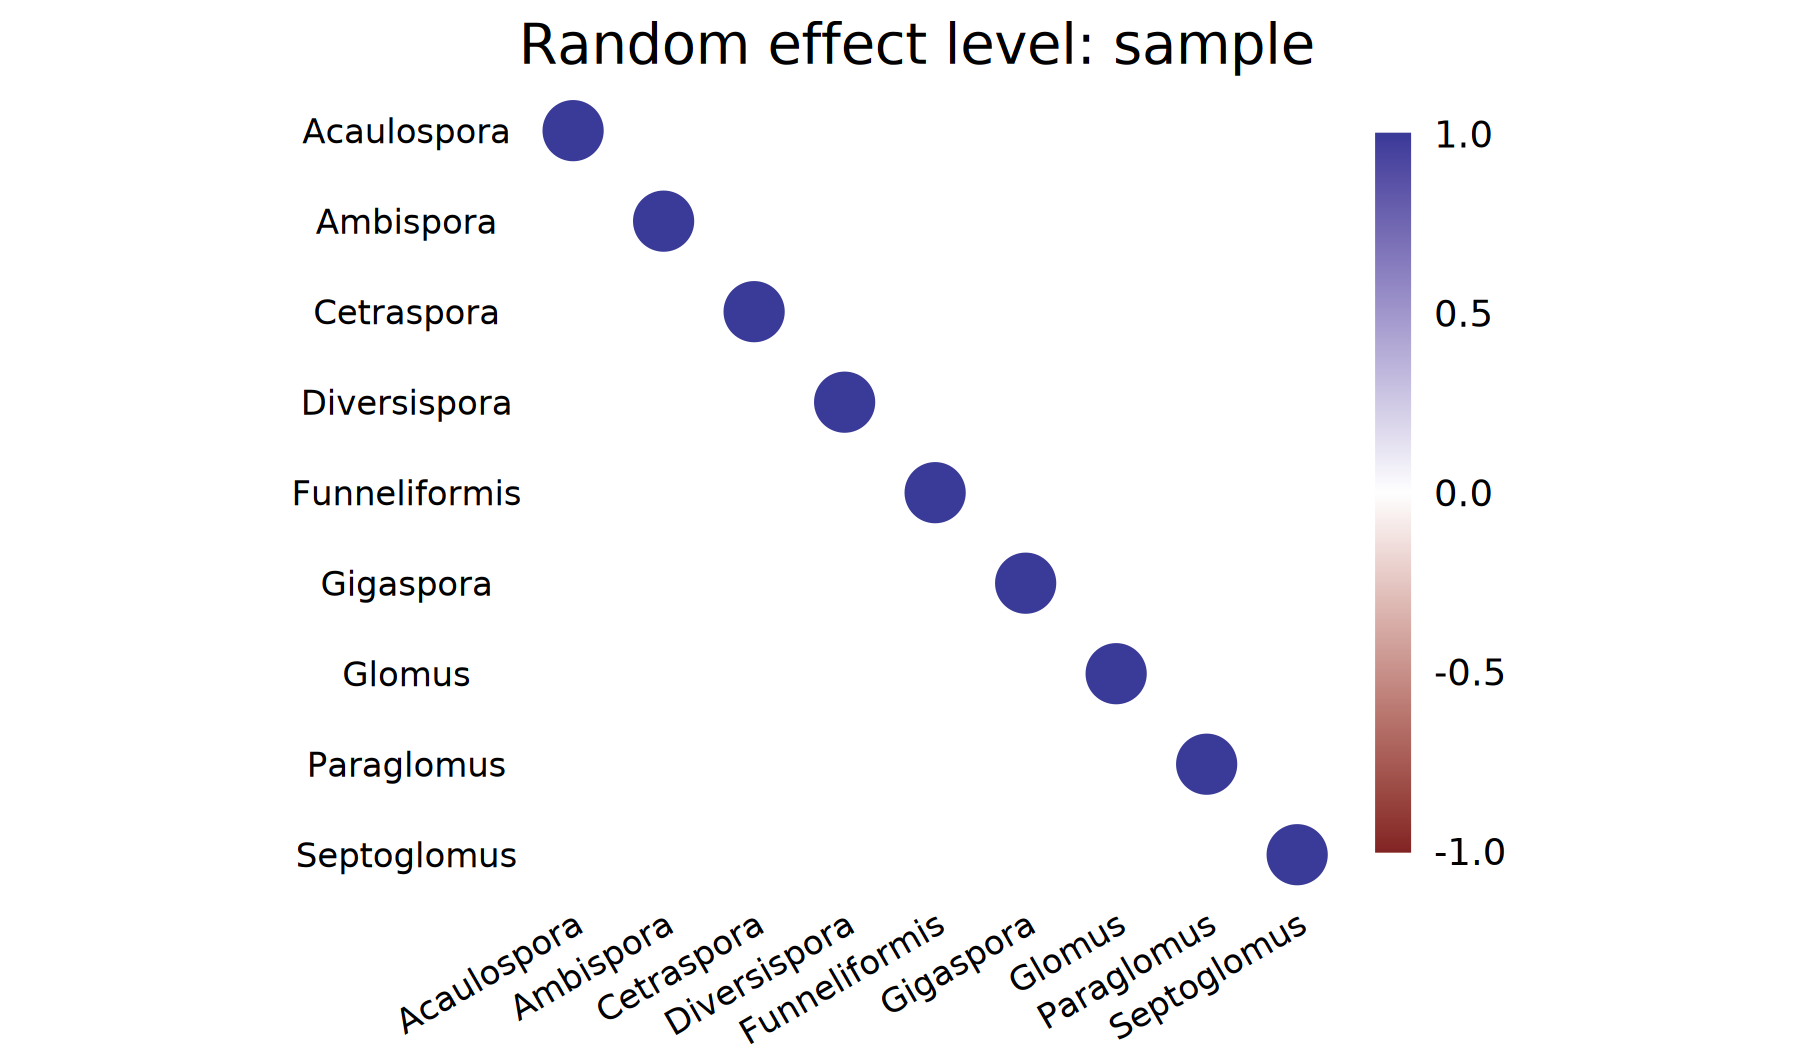

In [ ]:
genus_names <- c(
  "Acaulospora", "Ambispora", "Cetraspora", "Diversispora",
  "Funneliformis", "Gigaspora", "Glomus", "Paraglomus", "Septoglomus"
)
dataset_wide_grassland <- pivot_wider(
  dataset[
    dataset$Genus %in% genus_names,
    !(colnames(dataset) %in% c("abundance", "total", "proportion"))
  ],
  names_from = Genus, values_from = presence
)

dataset_wide_grassland <- mutate(
  dataset_wide_grassland,
  across(c(Biome, droughty), ~ as.factor(.x))
)

dataset_wide_grassland <- dataset_wide_grassland[dataset_wide_grassland$Biome == "grassland", ]

predictors <- c(
  # "pwsl1pomu", # Removed due to NA values
  "aws0_30", # Available water storage estimate, expressed in mm
  "rootznemc", # Root zone depth, expressed in cm
  "soc0_30", # Soil organic carbon stock estimate, grams C per square meter
  # "droughty", # “1” for a drought vulnerable soil or “0” for a non-droughty
  "tmax", # Max Temp 30 year normal (C)
  # "tmin", # Min Temp 30 year normal (C)
  # "tmean", # Mean Temp 30 year normal (C)
  # "vpdmax", # Daily Maximum Vapor Pressure Deficit 30 year normal (hPa)
  # "vpdmin", # Daily Minimum Vapor Pressure Deficit 30 year normal (hPa)
  "chirps" # Annual Precipitation in 2020 (mm)
  # "Biome" # Not in GIS layers
)

m <- Hmsc(
  Y = dataset_wide_grassland[genus_names],
  XData = dataset_wide_grassland[predictors],
  XFormula = ~
    aws0_30 +
    rootznemc +
    soc0_30 +
    tmax +
    chirps,
    # droughty +
    # pwsl1pomu +
    # tmin +
    # tmean +
    # vpdmax +
    # vpdmin +,
  studyDesign = data.frame(sample = as.factor(row.names(dataset_wide_grassland))),
  ranLevels = list(
    sample = HmscRandomLevel(units = as.factor(row.names(dataset_wide_grassland)))
  ),
  distr = "probit"
)
m <- sampleMcmc(
  m,
  thin = 5,
  samples = 5000,
  transient = 500,
  nChains = 8,
  nParallel = 8,
  verbose = 1
)

mpost <- convertToCodaObject(m)
par(mfrow = c(2, 2))
hist(effectiveSize(mpost$Beta), main = "ess(beta)", xlab = NULL)
hist(
  gelman.diag(mpost$Beta, multivariate = FALSE)$psrf,
  main = "psrf(beta)", xlab = NULL
)
hist(effectiveSize(mpost$Omega[[1]]), main = "ess(omega)", xlab = NULL)
hist(
  gelman.diag(mpost$Omega[[1]], multivariate = FALSE)$psrf,
  main = "psrf(omega)", xlab = NULL
)

par(mfrow = c(1, 1))
post_eta <- getPostEstimate(m, parName = "Beta")
plotBeta(
  m, post = post_eta, param = "Mean", supportLevel = 0.95,
  mar = c(5.3, 5, 0, 0), cex = c(0.5, 0.5, 0.5),
  spNamesNumbers = c(1, 0), covNamesNumbers = c(1, 0),
  smallplot = c(0.68, 0.7, 0.3, 0.8), mgp = c(0, 1.5, 0),
  colors = colorRampPalette(
    c(
      "red4", "red4", "red2", "red1", "white",
      "blue1", "blue2", "blue4", "blue4"
    )
  )
)
post_eta <- getPostEstimate(m, parName = "Beta")
plotBeta(
  m, post = post_eta, param = "Support", supportLevel = 0.95,
  mar = c(5.3, 5, 0, 0), cex = c(0.5, 0.5, 0.5),
  spNamesNumbers = c(1, 0), covNamesNumbers = c(1, 0),
  smallplot = c(0.68, 0.7, 0.3, 0.8), mgp = c(0, 1.5, 0),
  colors = colorRampPalette(
    c(
      "red4", "red4", "red2", "red1", "white",
      "blue1", "blue2", "blue4", "blue4"
    )
  )
)

omega_cor <- computeAssociations(m)
support_level <- 0.95
significant_omega_mean <- (
  (omega_cor[[1]]$support > support_level) +
    (omega_cor[[1]]$support < (1 - support_level)) > 0
) * omega_cor[[1]]$mean

# significant_omega_mean[lower.tri(significant_omega_mean)] <- NA
ggplot(
  data = pivot_longer(
    as_tibble(significant_omega_mean, rownames = "Var1"),
    cols = !Var1, names_to = "Var2"
  ),
  aes(x = Var1, y = Var2)
) +
  geom_point(aes(color = value, size = abs(value))) +
  guides(size = "none") +
  scale_color_gradient2(
    name = NULL, midpoint = 0, mid = "white", limits = c(-1, +1),
    na.value = "white",
  ) +
  scale_x_discrete(position = "bottom") +
  scale_y_discrete(limits = rev) +
  theme_void() +
  theme(
    axis.text.x = element_text(hjust = 1, vjust = 1, angle = 30, size = 8),
    axis.text.y = element_text(size = 8),
    aspect.ratio = 1,
    legend.key.width  = rel(0.5),
    legend.key.height = rel(2),
    legend.ticks = element_blank()
  ) +
  labs(
    title = paste("Random effect level:", m$rLNames[1]), x = NULL, y = NULL,
  )

preds <- computePredictedValues(m)
evaluateModelFit(hM = m, predY = preds)

## Anthropogenic Samples

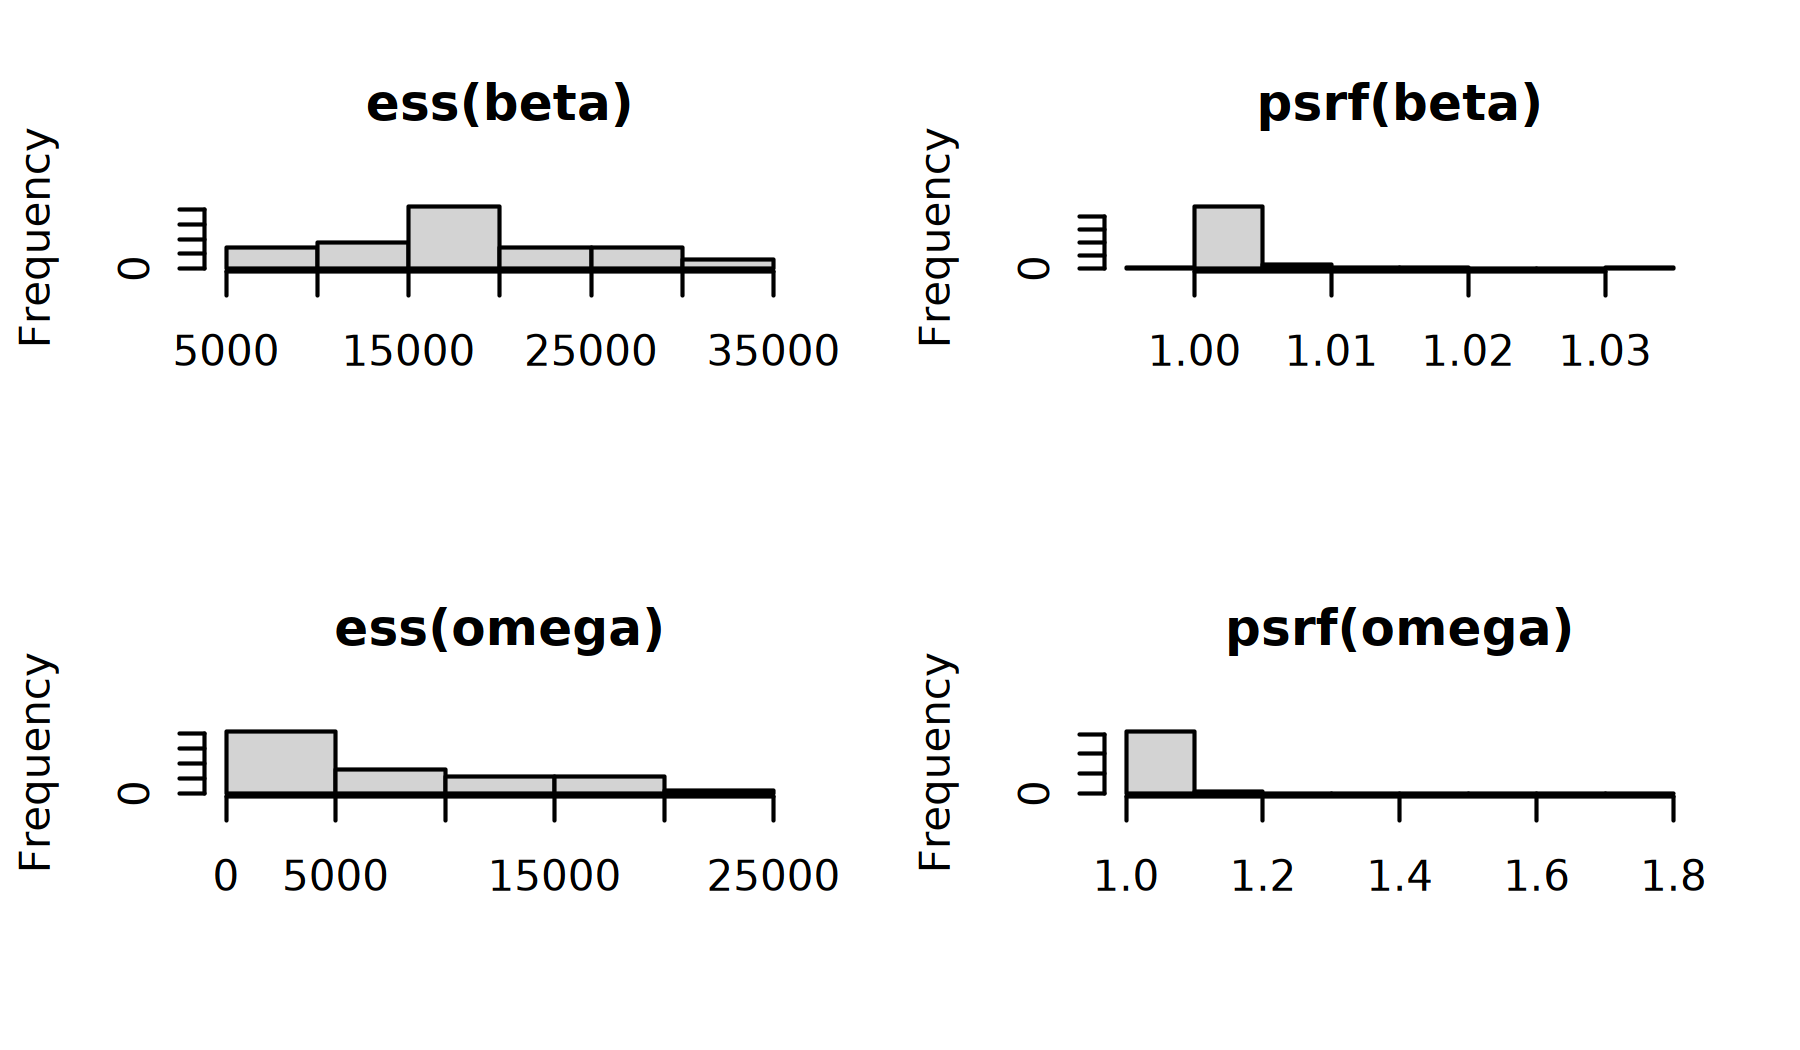

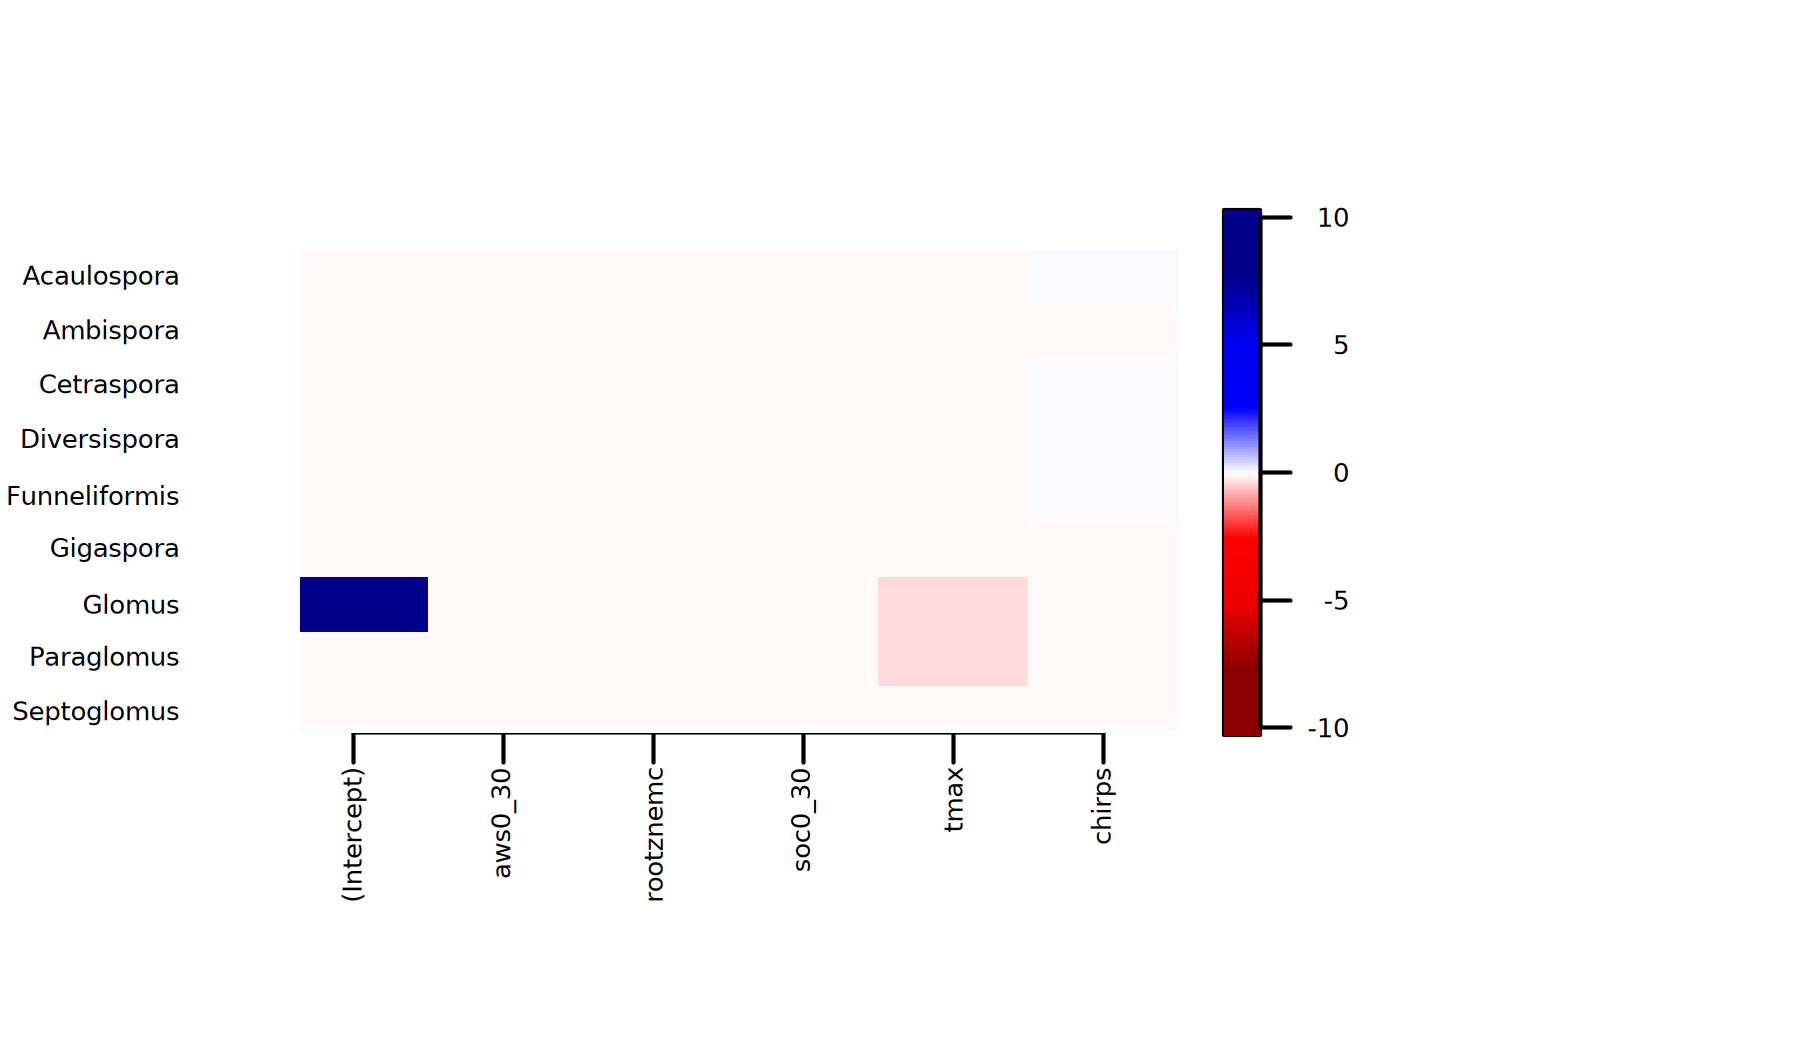

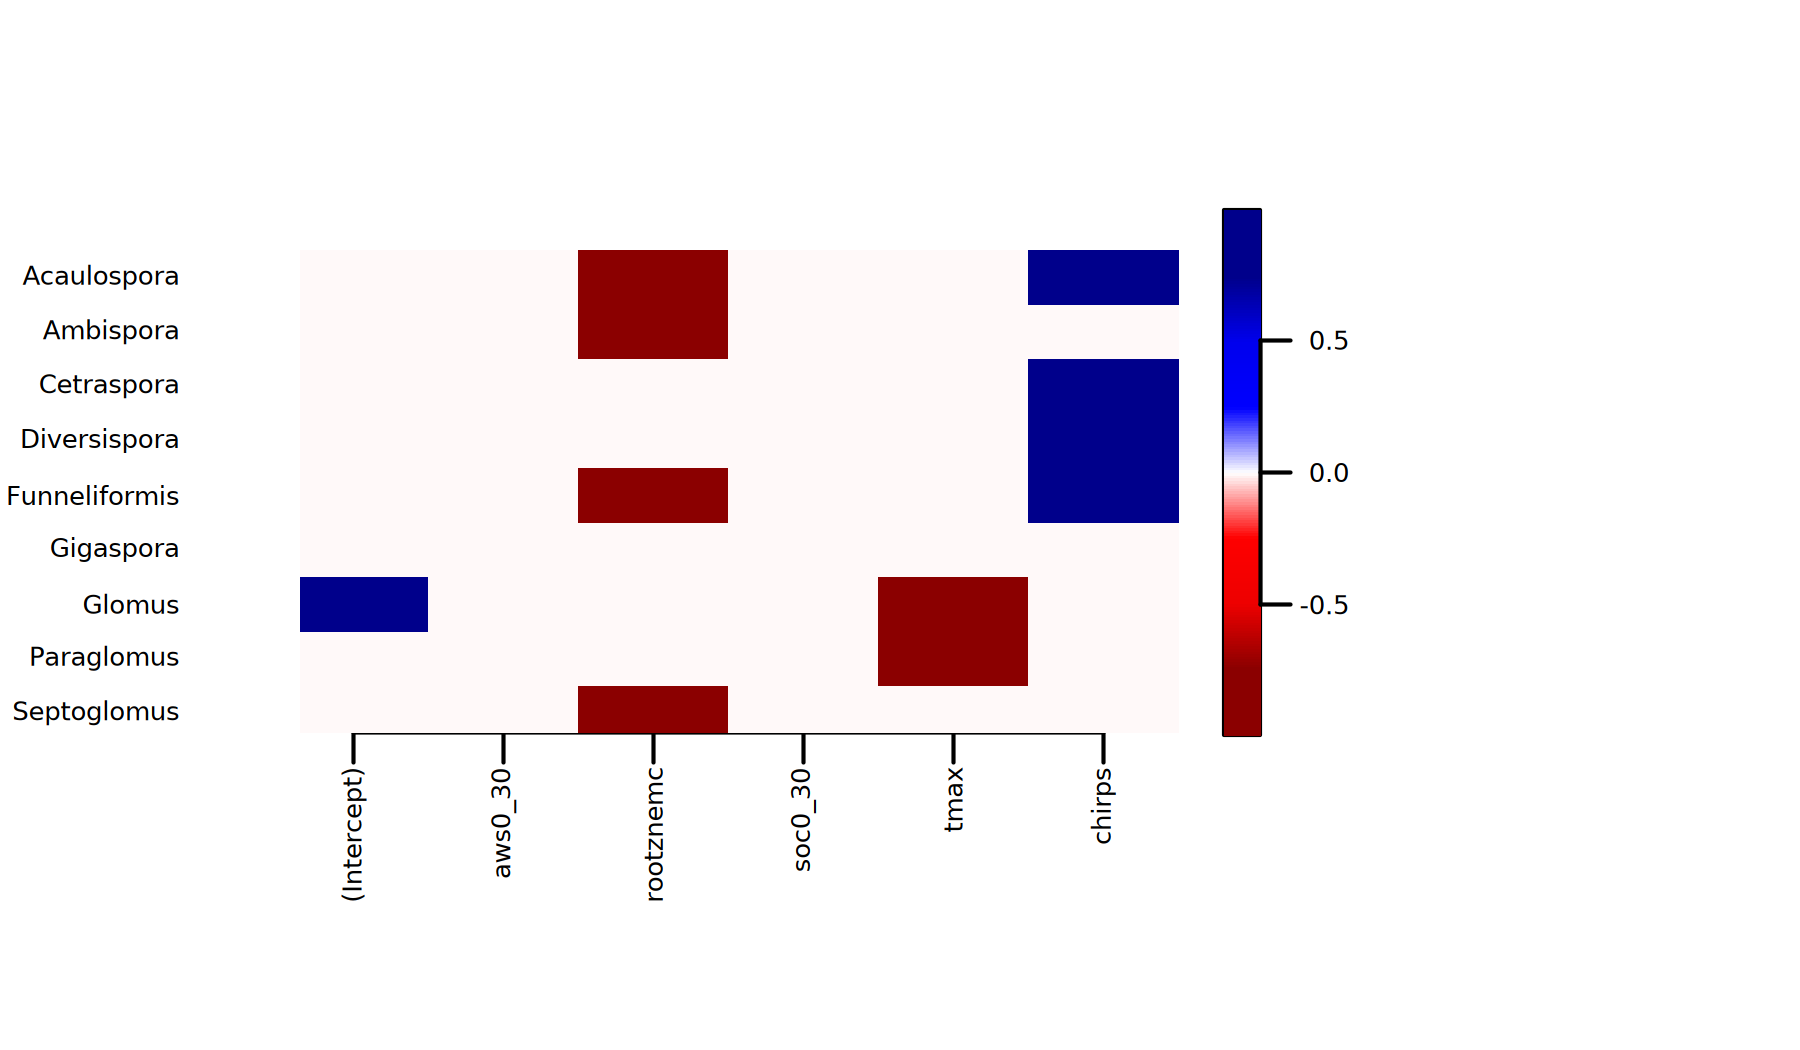

$RMSE
[1] 0.2313685 0.2337690 0.2269557 0.2411572 0.3680145 0.2122696 0.4234205
[8] 0.3284718 0.2226748

$AUC
[1] 0.9934334 0.8935484 0.9322581 0.9928571 0.8958724 1.0000000 0.7765568
[8] 0.9385027 0.9897959

$TjurR2
[1] 0.6315648 0.1914117 0.1839003 0.6349980 0.3581121 0.3942706 0.2278737
[8] 0.4602249 0.6101833

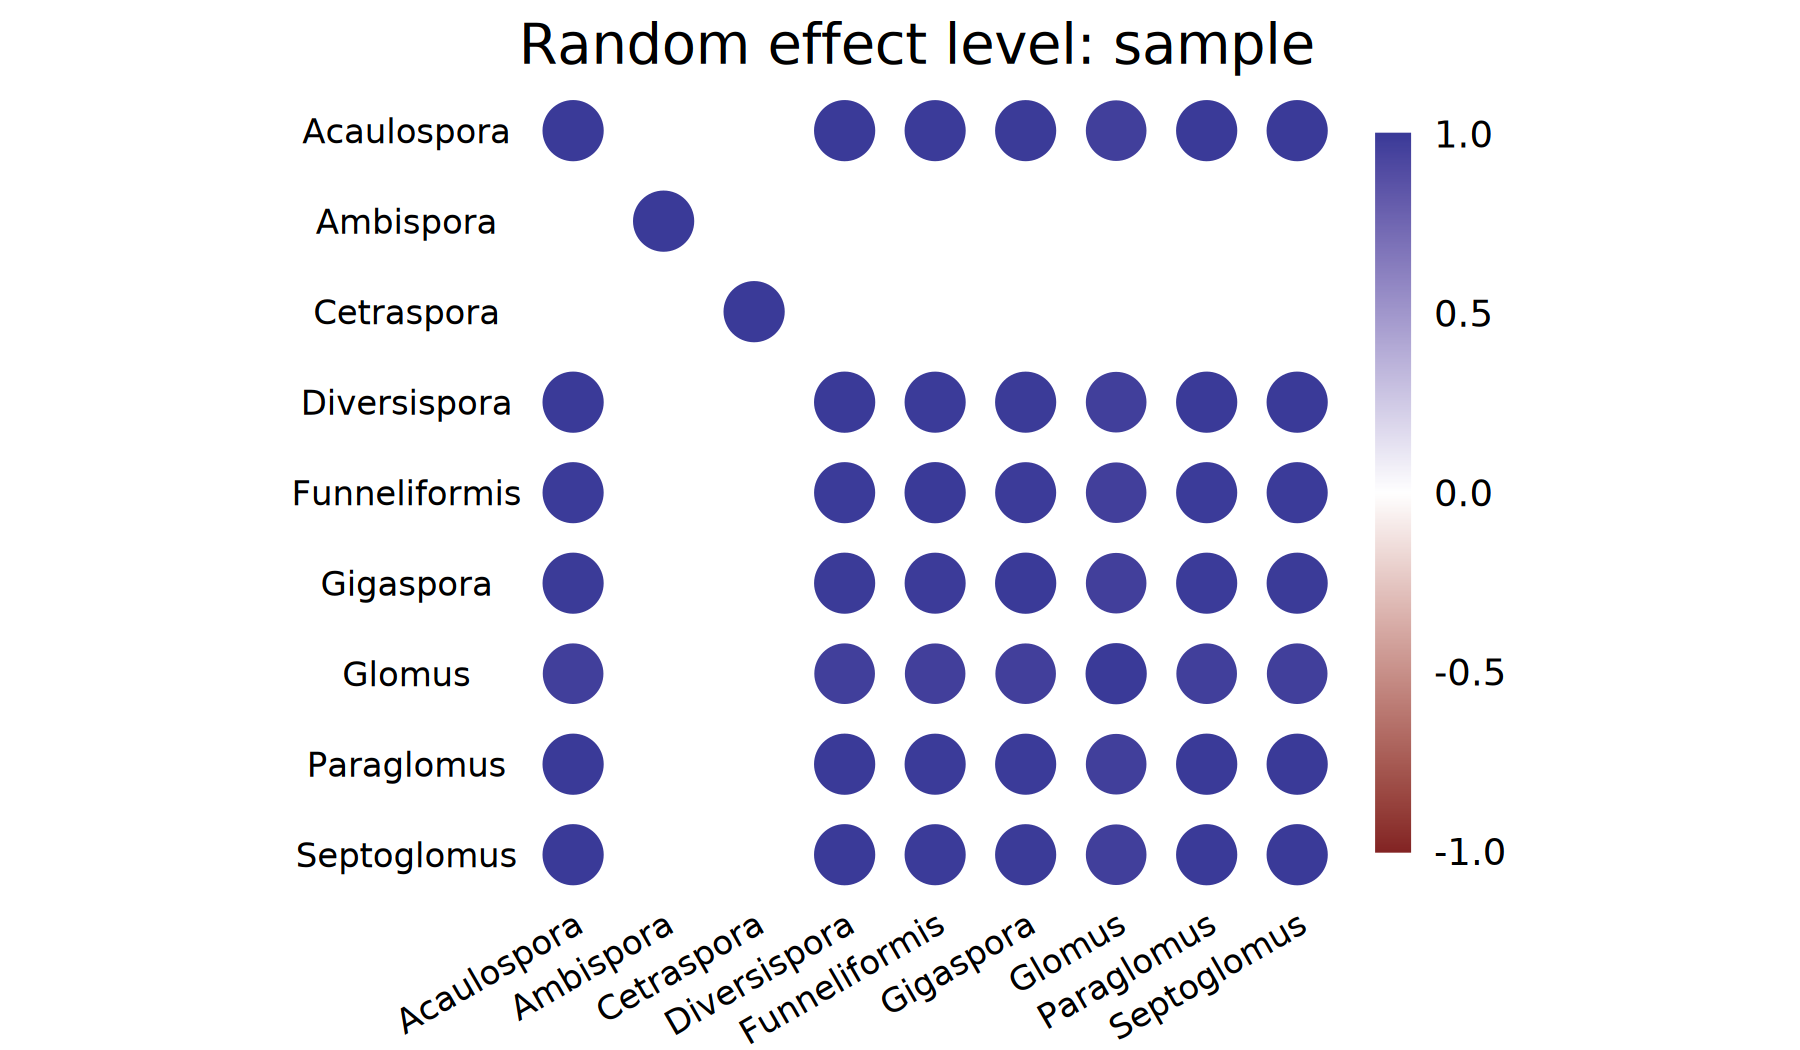

In [25]:
genus_names <- c(
  "Acaulospora", "Ambispora", "Cetraspora", "Diversispora",
  "Funneliformis", "Gigaspora", "Glomus", "Paraglomus", "Septoglomus"
)
dataset_wide_anthropogenic <- pivot_wider(
  dataset[
    dataset$Genus %in% genus_names,
    !(colnames(dataset) %in% c("abundance", "total", "proportion"))
  ],
  names_from = Genus, values_from = presence
)

dataset_wide_anthropogenic <- mutate(
  dataset_wide_anthropogenic,
  across(c(Biome, droughty), ~ as.factor(.x))
)

dataset_wide_anthropogenic <- dataset_wide_anthropogenic[dataset_wide_anthropogenic$Biome == "anthropogenic", ]

predictors <- c(
  # "pwsl1pomu", # Removed due to NA values
  "aws0_30", # Available water storage estimate, expressed in mm
  "rootznemc", # Root zone depth, expressed in cm
  "soc0_30", # Soil organic carbon stock estimate, grams C per square meter
  # "droughty", # “1” for a drought vulnerable soil or “0” for a non-droughty
  "tmax", # Max Temp 30 year normal (C)
  # "tmin", # Min Temp 30 year normal (C)
  # "tmean", # Mean Temp 30 year normal (C)
  # "vpdmax", # Daily Maximum Vapor Pressure Deficit 30 year normal (hPa)
  # "vpdmin", # Daily Minimum Vapor Pressure Deficit 30 year normal (hPa)
  "chirps" # Annual Precipitation in 2020 (mm)
  # "Biome" # Not in GIS layers
)

m <- Hmsc(
  Y = dataset_wide_anthropogenic[genus_names],
  XData = dataset_wide_anthropogenic[predictors],
  XFormula = ~
    aws0_30 +
    rootznemc +
    soc0_30 +
    tmax +
    chirps,
    # droughty +
    # pwsl1pomu +
    # tmin +
    # tmean +
    # vpdmax +
    # vpdmin +,
  studyDesign = data.frame(sample = as.factor(row.names(dataset_wide_anthropogenic))),
  ranLevels = list(
    sample = HmscRandomLevel(units = as.factor(row.names(dataset_wide_anthropogenic)))
  ),
  distr = "probit"
)
m <- sampleMcmc(
  m,
  thin = 5,
  samples = 5000,
  transient = 500,
  nChains = 8,
  nParallel = 8,
  verbose = 1
)

mpost <- convertToCodaObject(m)
par(mfrow = c(2, 2))
hist(effectiveSize(mpost$Beta), main = "ess(beta)", xlab = NULL)
hist(
  gelman.diag(mpost$Beta, multivariate = FALSE)$psrf,
  main = "psrf(beta)", xlab = NULL
)
hist(effectiveSize(mpost$Omega[[1]]), main = "ess(omega)", xlab = NULL)
hist(
  gelman.diag(mpost$Omega[[1]], multivariate = FALSE)$psrf,
  main = "psrf(omega)", xlab = NULL
)

par(mfrow = c(1, 1))
post_eta <- getPostEstimate(m, parName = "Beta")
plotBeta(
  m, post = post_eta, param = "Mean", supportLevel = 0.95,
  mar = c(5.3, 5, 0, 0), cex = c(0.5, 0.5, 0.5),
  spNamesNumbers = c(1, 0), covNamesNumbers = c(1, 0),
  smallplot = c(0.68, 0.7, 0.3, 0.8), mgp = c(0, 1.5, 0),
  colors = colorRampPalette(
    c(
      "red4", "red4", "red2", "red1", "white",
      "blue1", "blue2", "blue4", "blue4"
    )
  )
)
post_eta <- getPostEstimate(m, parName = "Beta")
plotBeta(
  m, post = post_eta, param = "Support", supportLevel = 0.95,
  mar = c(5.3, 5, 0, 0), cex = c(0.5, 0.5, 0.5),
  spNamesNumbers = c(1, 0), covNamesNumbers = c(1, 0),
  smallplot = c(0.68, 0.7, 0.3, 0.8), mgp = c(0, 1.5, 0),
  colors = colorRampPalette(
    c(
      "red4", "red4", "red2", "red1", "white",
      "blue1", "blue2", "blue4", "blue4"
    )
  )
)

omega_cor <- computeAssociations(m)
support_level <- 0.95
significant_omega_mean <- (
  (omega_cor[[1]]$support > support_level) +
    (omega_cor[[1]]$support < (1 - support_level)) > 0
) * omega_cor[[1]]$mean

# significant_omega_mean[lower.tri(significant_omega_mean)] <- NA
ggplot(
  data = pivot_longer(
    as_tibble(significant_omega_mean, rownames = "Var1"),
    cols = !Var1, names_to = "Var2"
  ),
  aes(x = Var1, y = Var2)
) +
  geom_point(aes(color = value, size = abs(value))) +
  guides(size = "none") +
  scale_color_gradient2(
    name = NULL, midpoint = 0, mid = "white", limits = c(-1, +1),
    na.value = "white",
  ) +
  scale_x_discrete(position = "bottom") +
  scale_y_discrete(limits = rev) +
  theme_void() +
  theme(
    axis.text.x = element_text(hjust = 1, vjust = 1, angle = 30, size = 8),
    axis.text.y = element_text(size = 8),
    aspect.ratio = 1,
    legend.key.width  = rel(0.5),
    legend.key.height = rel(2),
    legend.ticks = element_blank()
  ) +
  labs(
    title = paste("Random effect level:", m$rLNames[1]), x = NULL, y = NULL,
  )

preds <- computePredictedValues(m)
evaluateModelFit(hM = m, predY = preds)

## Single Species Grassland

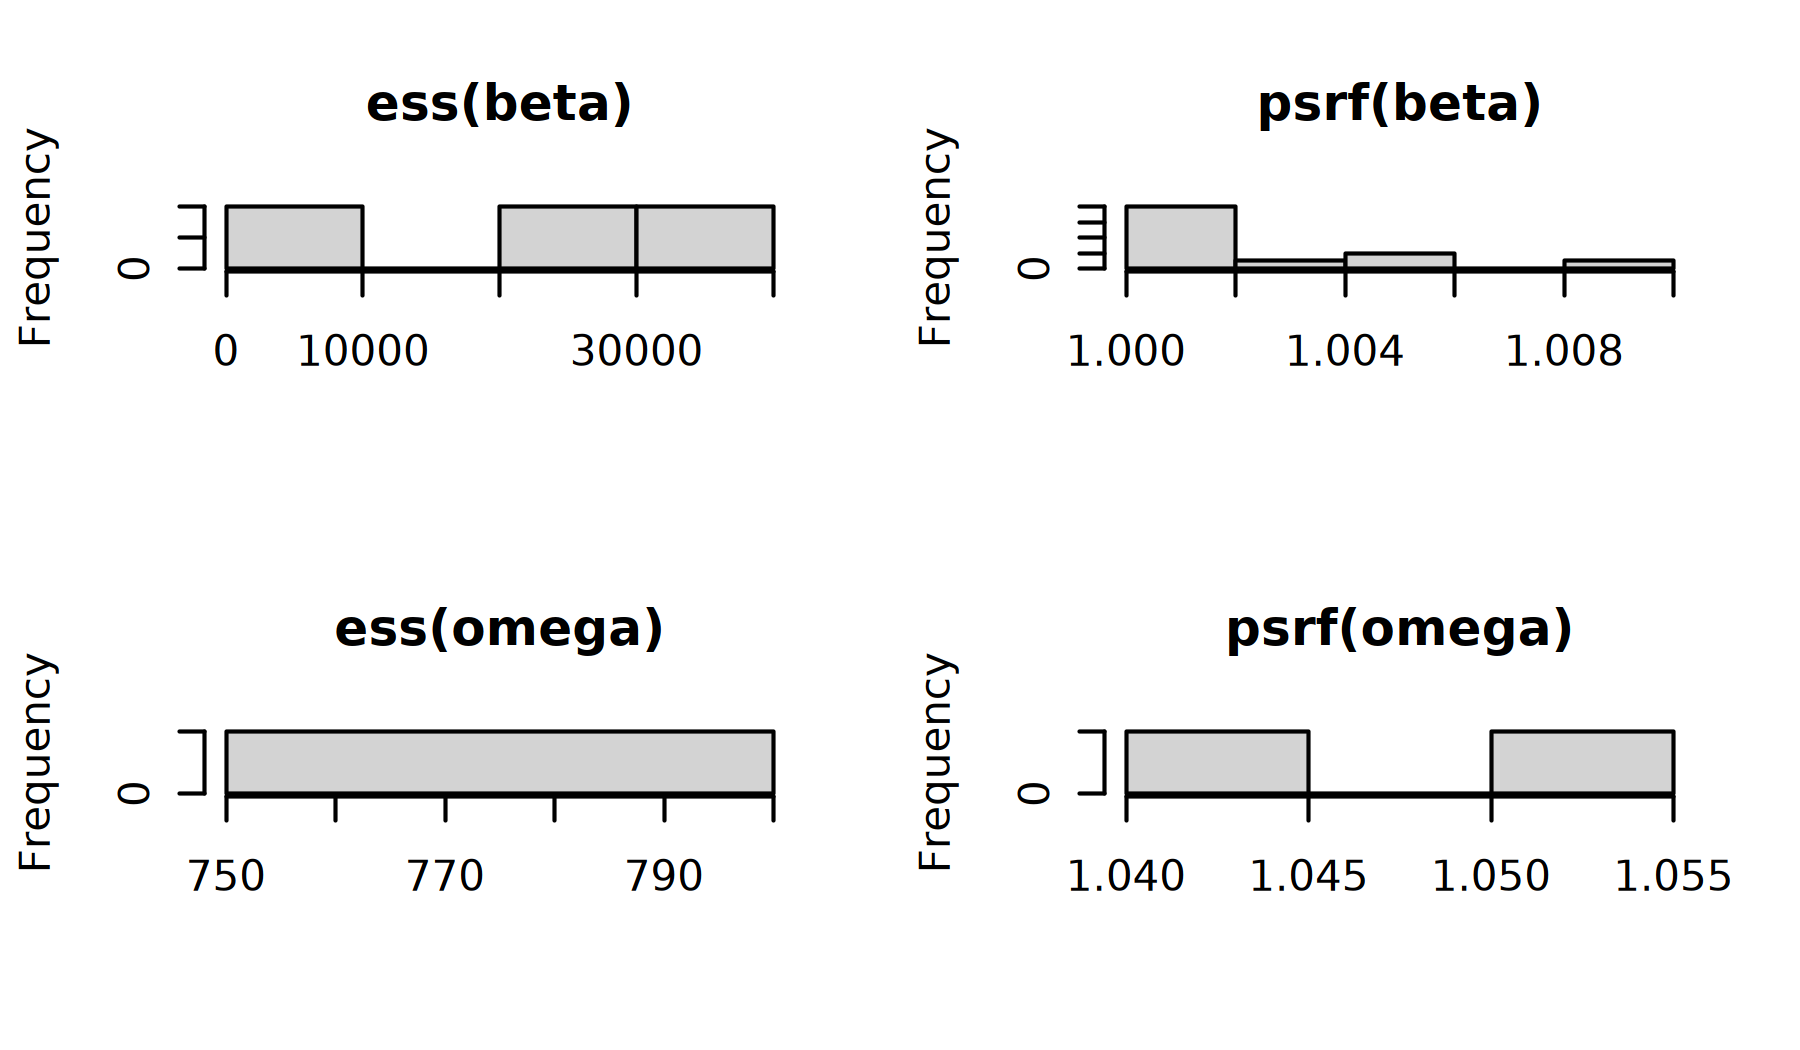

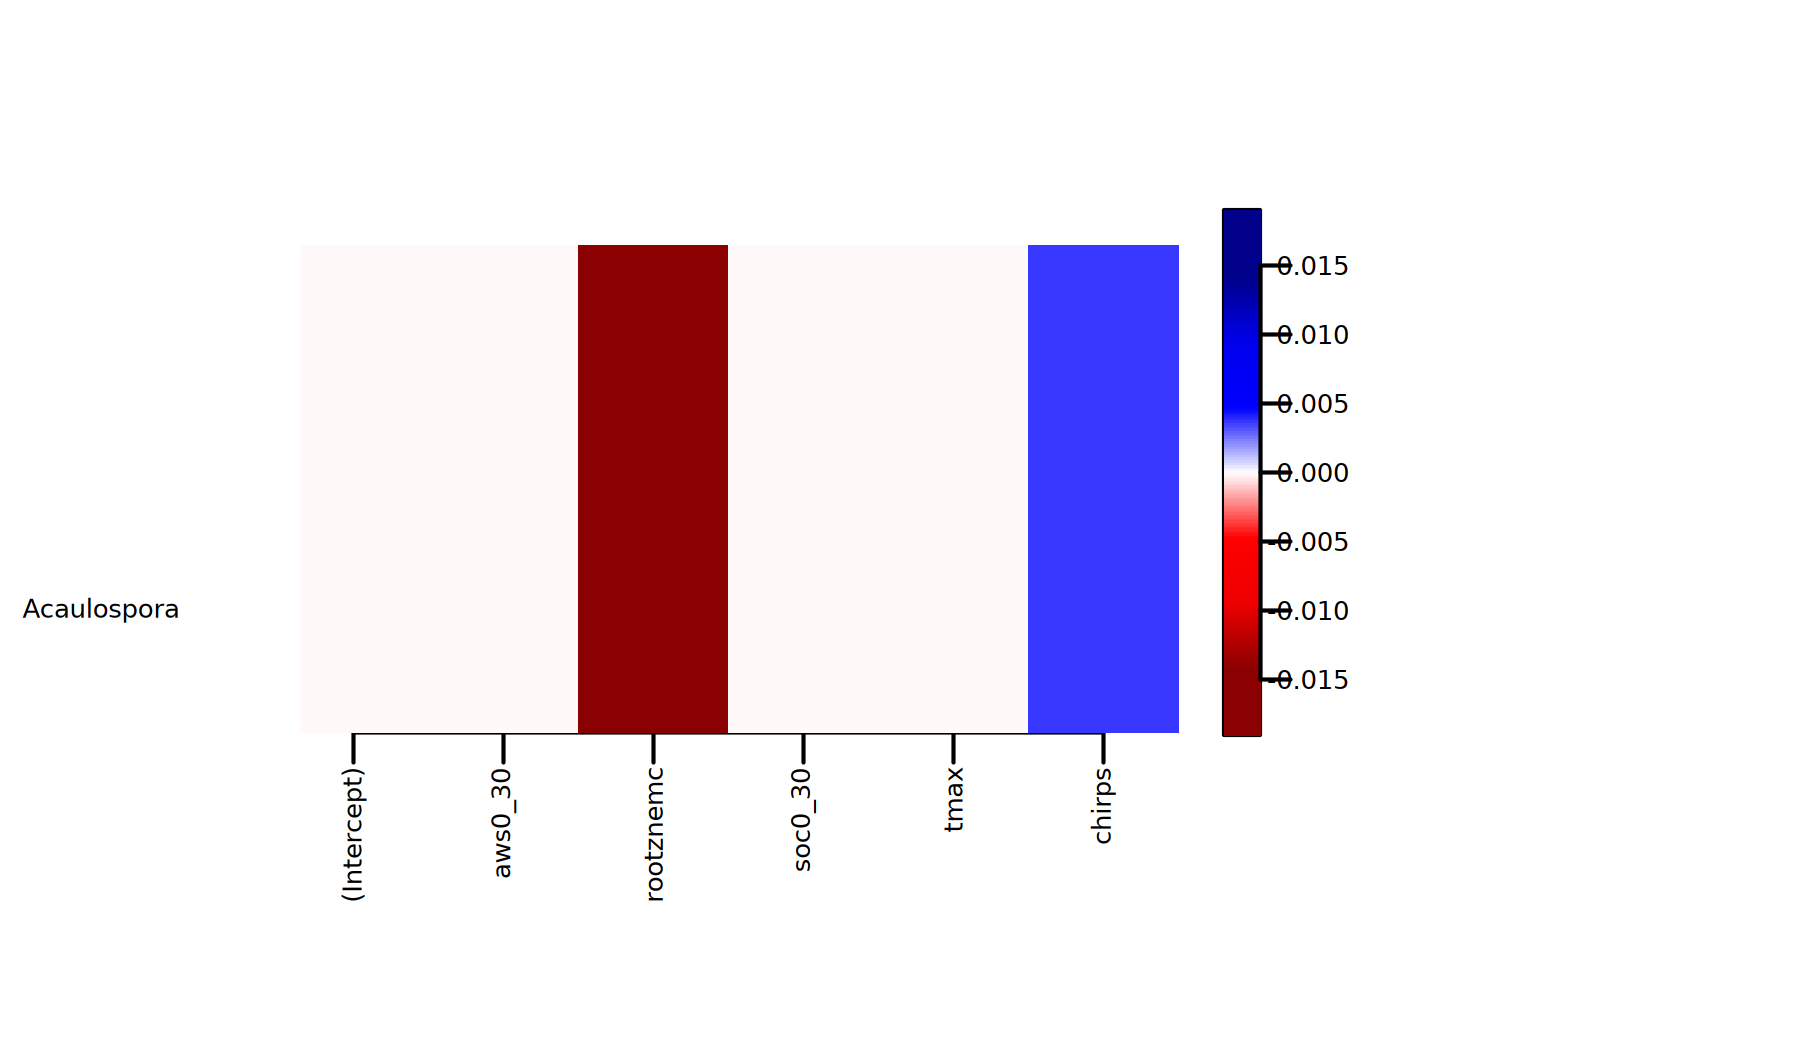

$RMSE
[1] 0.4167747

$AUC
[1] 0.8476874

$TjurR2
[1] 0.2326616

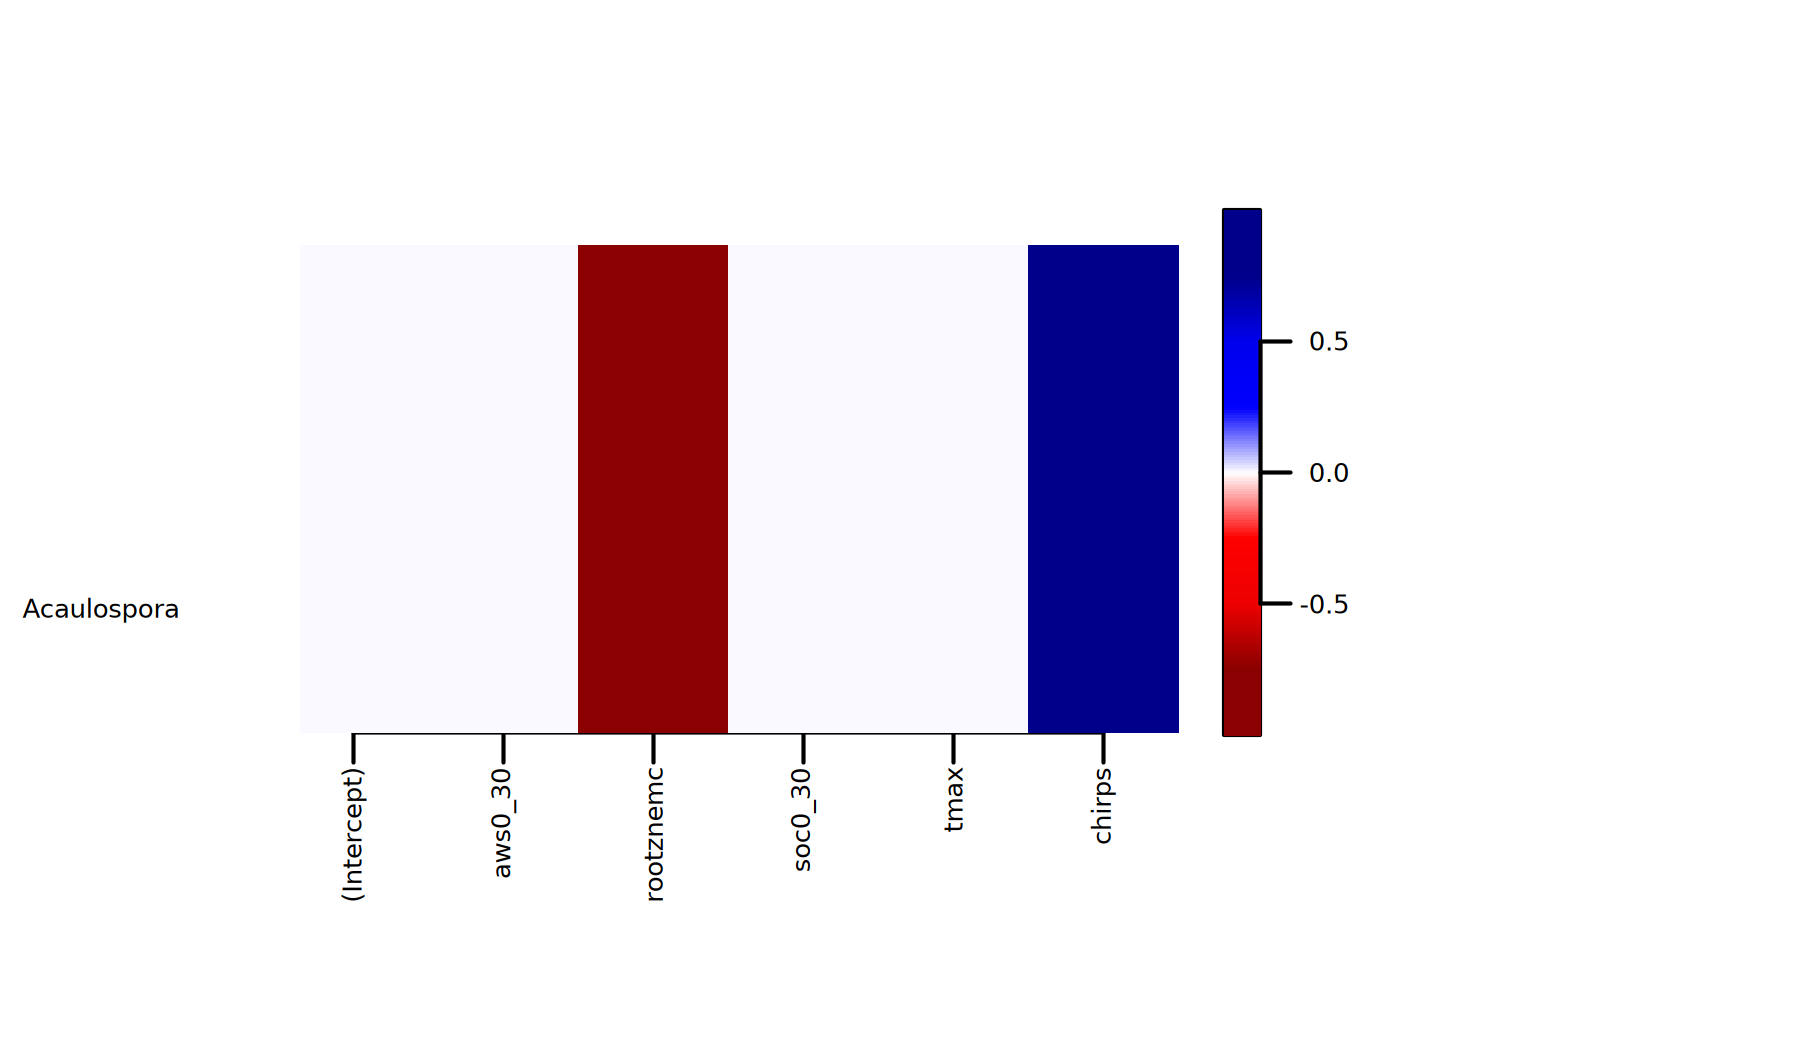

In [28]:
genus_names <- c(
  "Acaulospora"
)
dataset_wide_grassland <- pivot_wider(
  dataset[
    dataset$Genus %in% genus_names,
    !(colnames(dataset) %in% c("abundance", "total", "proportion"))
  ],
  names_from = Genus, values_from = presence
)

dataset_wide_grassland <- mutate(
  dataset_wide_grassland,
  across(c(Biome, droughty), ~ as.factor(.x))
)

dataset_wide_grassland <- dataset_wide_grassland[dataset_wide_grassland$Biome == "grassland", ]

predictors <- c(
  # "pwsl1pomu", # Removed due to NA values
  "aws0_30", # Available water storage estimate, expressed in mm
  "rootznemc", # Root zone depth, expressed in cm
  "soc0_30", # Soil organic carbon stock estimate, grams C per square meter
  # "droughty", # “1” for a drought vulnerable soil or “0” for a non-droughty
  "tmax", # Max Temp 30 year normal (C)
  # "tmin", # Min Temp 30 year normal (C)
  # "tmean", # Mean Temp 30 year normal (C)
  # "vpdmax", # Daily Maximum Vapor Pressure Deficit 30 year normal (hPa)
  # "vpdmin", # Daily Minimum Vapor Pressure Deficit 30 year normal (hPa)
  "chirps" # Annual Precipitation in 2020 (mm)
  # "Biome" # Not in GIS layers
)

m <- Hmsc(
  Y = dataset_wide_grassland[genus_names],
  XData = dataset_wide_grassland[predictors],
  XFormula = ~
    aws0_30 +
    rootznemc +
    soc0_30 +
    tmax +
    chirps,
    # droughty +
    # pwsl1pomu +
    # tmin +
    # tmean +
    # vpdmax +
    # vpdmin +,
  studyDesign = data.frame(sample = as.factor(row.names(dataset_wide_grassland))),
  ranLevels = list(
    sample = HmscRandomLevel(units = as.factor(row.names(dataset_wide_grassland)))
  ),
  distr = "probit"
)
m <- sampleMcmc(
  m,
  thin = 5,
  samples = 5000,
  transient = 500,
  nChains = 8,
  nParallel = 8,
  verbose = 1
)

mpost <- convertToCodaObject(m)
par(mfrow = c(2, 2))
hist(effectiveSize(mpost$Beta), main = "ess(beta)", xlab = NULL)
hist(
  gelman.diag(mpost$Beta, multivariate = FALSE)$psrf,
  main = "psrf(beta)", xlab = NULL
)
hist(effectiveSize(mpost$Omega[[1]]), main = "ess(omega)", xlab = NULL)
hist(
  gelman.diag(mpost$Omega[[1]], multivariate = FALSE)$psrf,
  main = "psrf(omega)", xlab = NULL
)

par(mfrow = c(1, 1))
post_eta <- getPostEstimate(m, parName = "Beta")
plotBeta(
  m, post = post_eta, param = "Mean", supportLevel = 0.95,
  mar = c(5.3, 5, 0, 0), cex = c(0.5, 0.5, 0.5),
  spNamesNumbers = c(1, 0), covNamesNumbers = c(1, 0),
  smallplot = c(0.68, 0.7, 0.3, 0.8), mgp = c(0, 1.5, 0),
  colors = colorRampPalette(
    c(
      "red4", "red4", "red2", "red1", "white",
      "blue1", "blue2", "blue4", "blue4"
    )
  )
)
post_eta <- getPostEstimate(m, parName = "Beta")
plotBeta(
  m, post = post_eta, param = "Support", supportLevel = 0.95,
  mar = c(5.3, 5, 0, 0), cex = c(0.5, 0.5, 0.5),
  spNamesNumbers = c(1, 0), covNamesNumbers = c(1, 0),
  smallplot = c(0.68, 0.7, 0.3, 0.8), mgp = c(0, 1.5, 0),
  colors = colorRampPalette(
    c(
      "red4", "red4", "red2", "red1", "white",
      "blue1", "blue2", "blue4", "blue4"
    )
  )
)

preds <- computePredictedValues(m)
evaluateModelFit(hM = m, predY = preds)

In [ ]:
gis_dataset_aggregate <- aggregate(midwest_gis_dataset, 10, "median")
plot(gis_dataset_aggregate)

gradient <- prepareGradient(
  m,
  na.omit(data.frame(gis_dataset_aggregate)[
    names(gis_dataset_aggregate) %in% predictors
  ]),
  list(route = crds(gis_dataset_aggregate))
)
pred_y <- predict(
  m,
  Gradient = gradient
)
pred_y

## Latent Variable Plot

In [ ]:
rl <- HmscRandomLevel(units = as.factor(row.names(dataset_wide)))
rl$nfMin <- 2
rl$nfMax <- 2
m <- Hmsc(
  Y = dataset_wide[genus_names],
  XData = dataset_wide[predictors],
  XFormula = ~ 1,
  studyDesign = data.frame(sample = as.factor(row.names(dataset_wide))),
  ranLevels = list(sample = rl)
)
m <- sampleMcmc(
  m,
  thin = 5,
  samples = 5000,
  transient = 500,
  nChains = 8,
  nParallel = 8,
  verbose = 1
)

eta_post <- getPostEstimate(m, "Eta")
lambda_post <- getPostEstimate(m, "Lambda")
biPlot(m, etaPost = eta_post, lambdaPost = lambda_post, factors = c(1, 2))

## Regressions

In [ ]:
for(genus in genus_names) {
  histogram_plot <- ggplot(data = dataset[dataset$Genus == genus, ]) +
    geom_histogram(aes(x = log(abundance / total))) +
    labs(title = genus)
  print(histogram_plot)

  model <- glm(
    cbind(abundance, total - abundance) ~
      aws0_30 +
      # pwsl1pomu +
      rootznemc +
      soc0_30 +
      droughty +
      tmax +
      tmin +
      tmean +
      vpdmax +
      vpdmin +
      chirps
    ,
    family = binomial(link = "probit"),
    data = dataset[dataset$Genus == genus, ]
  )
  print(summary(model))

  output <- predict(midwest_gis_dataset, model)
  niche_model_map <- ggplot() +
    geom_spatraster(data = output, aes(fill = lyr1)) +
    labs(x = NULL, y = NULL, title = genus) +
    scale_x_continuous(breaks = seq(-180, 180, 2)) +
    scale_y_continuous(breaks = seq(-90, 90, 2)) +
    scale_fill_gradient2(
      low = "darkred",
      mid = "darkgrey",
      high = "darkblue",
      na.value = "black",
      midpoint = 0
    ) +
    theme(
      legend.position = "right",
      legend.direction = "vertical",
      axis.text.y = element_text(angle = 90, hjust = 0.5)
    )
  print(niche_model_map)
}

In [ ]:
dbDisconnect(con, shutdown = TRUE)